# 1. Introduction

Voir le notebook de description

# 2. Démarche méthodologique

Voir le notebook de description

# 3. Exploration des données

## <a name="C31">3.1 Chargement<a>

### <a name="C2311">3.1.1 Importation des librairies utiles et options<a>

In [165]:
import numpy as np
import pandas as pd
from preprocessing import *
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.cluster import KMeans
import shap
from shap import TreeExplainer
from shap import summary_plot
import lime
from lime import lime_tabular
import random

#estimator
from sklearn.dummy import DummyClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb
import xgboost as xgb

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV


from sklearn.preprocessing import LabelEncoder # pour transformer données de type string en données numérique
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm #pour utiliser svm_svc
from sklearn import neighbors, metrics

#metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import PolynomialFeatures

In [2]:
#Pour eviter de tronquer les listes affichées car le dataset est important en terme de taille
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### <a name="C312">3.1.2 Les fonctions</a>

#### <a name="C3121">3.1.2.1 Matrice de confusion</a>

In [3]:
def confusion(y_test,y_pred) :
    '''affiche une matrice de confusion bien comprehensible'''
    mat=confusion_matrix(y_test,y_pred)
    mat=pd.DataFrame(mat)
    mat.columns=[f"pred_{i}" for i in mat.columns]
    mat.index=[f"test_{i}" for i in mat.index]
    return mat #pour afficher la matrice de confusion lors de l'appel de la fonction

#### <a name="C3122">3.1.2.2 Score</a>

In [4]:
def score(estimator, y_pred,X_train,X_test,y_train,y_test):
    print("La proportion de target dans le jeu d'entrainement :")
    print(y_train.value_counts(normalize=True))
    print("La proportion des prédictions faite est :")
    print(pd.Series(y_pred).value_counts(normalize=True)) #Pour utiliser value_counts, il faut transformer notre vecteur en series
    print("--------------------------------------------------------------------------------")
    print("Voici les résultats :")
    tr_score=estimator.score(X_train,y_train).round(4)
    te_score=estimator.score(X_test,y_test).round(4)
    print(f"score train : {tr_score} ; score test : {te_score}")
    print("----------------------------------------")
    display(confusion(y_test, y_pred))
    print("----------------------------------------")
    print(classification_report(y_test,y_pred))
    print("----------------------------------------")
    #Pour tous les cas sauf K-means:
    print("L'aire sous la courbe ROC est :",round(roc_auc_score(y_test,y_pred),2))
       
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)

    
    plt.figure(figsize=(10,10))
    plt.title("Receiver Operator Characteristic - ROC")
    plt.plot(false_positive_rate, true_positive_rate, color='red',label='AUC =%0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],linestyle='--')
    plt.axis('tight')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

In [5]:
def score_ponderation(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    f1=(2*tp)/(2*tp+fp+fn)
    print("F1=",f1)
    f1p=(2*tp)/(2*tp+(1*fp)+(10*fn))
    print("F1 pondéré=",f1p)
    
    print("----------------------------------------")
    display(confusion(y_test, y_pred))
    print("----------------------------------------")
    print(classification_report(y_test,y_pred))


In [6]:
def score_multiclass(estimator, y_pred,X_train,X_test,y_train,y_test):
    print("La proportion de target dans le jeu d'entrainement :")
    print(y_train.value_counts(normalize=True))
    print("La proportion des prédictions faite est :")
    print(pd.Series(y_pred).value_counts(normalize=True)) #Pour utiliser value_counts, il faut transformer notre vecteur en series
    print("--------------------------------------------------------------------------------")
    print("Voici les résultats :")
    tr_score=estimator.score(X_train,y_train).round(4)
    te_score=estimator.score(X_test,y_test).round(4)
    print(f"score train : {tr_score} ; score test : {te_score}")
    print("----------------------------------------")
    display(confusion(y_test, y_pred))
    print("----------------------------------------")
    print(classification_report(y_test,y_pred))
    print("----------------------------------------")
    
    #print("L'aire sous la courbe ROC est :",round(roc_auc_score(y_test,y_pred, multi_class='ovo'),2))
       
    
    #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    #roc_auc=auc(false_positive_rate, true_positive_rate)

    
    #plt.figure(figsize=(10,10))
    #plt.title("Receiver Operator Characteristic - ROC")
    #plt.plot(false_positive_rate, true_positive_rate, color='red',label='AUC =%0.2f' % roc_auc)
    #plt.legend(loc='lower right')
    #plt.plot([0,1],[0,1],linestyle='--')
    #plt.axis('tight')
    #plt.xlabel("False positive rate")
    #plt.ylabel("True positive rate")
    #plt.show()
    

#### <a name="C3123">3.1.2.3 Standardisation</a>

In [7]:
def standardisation(X,i_std_scaled,switch=True):# true = Systématiquement dans le cas de Train. 
    

    #Séparation des dataframe en numérique et catégrorielle pour la standardisation
    X_num=X.select_dtypes(include=['int64','float64'] )
    X_obj=X.select_dtypes(include=['object'] )
    
    l_std_scaled=i_std_scaled
    
    if (switch) :
        #Standardisation des variables numériques
        l_std_scaled = preprocessing.StandardScaler().fit(X_num)
    
    
    X_num_std = pd.DataFrame(l_std_scaled.transform(X_num))
    
    #Renommage des colonnes suite à la perte des noms lors de la standardisation
    X_num_std.columns=X_num.columns
    
    # Récupération des numéro d'index du dataframe objet pour le dataframe num
    X_num_std.index=X_obj.index
    
    #Rassemblement de Xtrain puis de  X_test par l'index
    X=pd.merge(X_num_std, X_obj, left_index=True, right_index=True)
    print(f"Nous avons X de forme {X.shape}")
    
    return X, l_std_scaled

#### <a name="C3124">3.1.2.4 Equilibrage Target</a>

In [8]:
def reequilibrage_target_smotenc(X,y):
    print("Avant équilibrage :")
    print(f"Nous avons X de forme {X.shape} et y de forme {y.shape}")
    print("TARGET :")
    print(Counter(y).keys())
    print(Counter(y).values())
    print("--------------")
    # Définition de l'instance SMOTE ; sampling strategy =1 (pour équilibrer à 50/50)
    #sm = SMOTENC(categorical_features=[24,25,26,27,28,29,30,31,32,33,34,35], sampling_strategy=1, k_neighbors=2)
    
    #df_app_train de base :
    sm = SMOTENC(categorical_features=[0,1,2,3,9,10,11,12,17,19,20,21], sampling_strategy=1, k_neighbors=2)
    
    #df_app_train réduite ACP:
    #sm = SMOTENC(categorical_features=[0,1,2,3,6,7,8,9,14,16,17,18], sampling_strategy=1, k_neighbors=2)
    
    #df_app_train polynomiale feature
    #sm = SMOTENC(categorical_features=[0,1,2,3,4,9,10,11,12,17,19,20,21], sampling_strategy=1, k_neighbors=2)
    
    #df_app_train KMeans
    #sm = SMOTENC(categorical_features=[0,1,2,3,9,10,11,12,17,19,20,21,35], sampling_strategy=1, k_neighbors=2)
    
    # Application du SMOTE aux données
    X, y = sm.fit_resample(X, y)
    print("Après équilibrage :")
    print(f"Nous avons X de forme {X.shape} et y de forme {y.shape}")
    print("TARGET :")
    print(Counter(y).keys())
    print(Counter(y).values())
    
    return X,y

In [9]:
#df_app_train.info()

#### <a name="C3125">3.1.2.5 Encodage objet</a>

In [10]:
def encodage_objet(X):
    # Création de l'objet laber encoder
    le = LabelEncoder()
    le_count = 0
    #Selection des colonnes "objet" qui ne contiennent que 2 valeurs uniques
    for col in X:
        if X[col].dtype == 'object':
            # Si 2 valeurs uniques ou moins
            if len(list(X[col].unique())) <= 2:
                # On entraine
                le.fit(X[col])
                # Transformation des données d'entrainement et de test
                X[col] = le.transform(X[col])
                # Surveillance de combien de colonne ont été encodées 
                le_count += 1

    print('%d colonnes ont étés "label encodée.' % le_count)
    
    # one-hot encoding pour les variables catégorielles ayant plus de 2 valeurs uniques
    X= pd.get_dummies(X)
    print("Après label encoding et one hot encoding, nous avons maintenant X ayant cette forme :", X.shape)
    
    return X

#### <a name="C3126">3.1.2.6 Dummy Classifier</a>

In [11]:
def dummyC(X_train,X_test,y_train,y_test, strategy):
    
    #Instanciation de l'objet "DummyClassifier" et on le stocke l'objet instancier dans une variable estimator
    estimator=DummyClassifier(strategy=strategy)
    
    #Entrainement de l'estimateur grace à la méthode fit
    estimator.fit(X_train, y_train)
    
    #Maintenant que estimator est entrainé, on peut appeller predict sur X_test
    y_pred=estimator.predict(X_test)
    
    return estimator, y_pred

#### <a name="C3127">3.1.2.7 Regression logistic</a>

In [12]:
def logisticR(X_train, X_test, y_train, y_test, solver,class_weight ):
    
    estimator=LogisticRegression(solver=solver,class_weight=class_weight)
    #Entrainement de l'estimateur grace à la méthode fit
    estimator.fit(X_train, y_train)

    
     #Maintenant que estimator est entrainé, on peut appeller predict sur X_test
    y_pred=estimator.predict(X_test)

    return estimator, y_pred

#### <a name="C3128">3.1.2.8 LinearSVC</a>

In [13]:
def linearSVC(X_train, X_test, y_train, y_test, class_weight):
    estimator=LinearSVC(class_weight=class_weight)
    #Entrainement de l'estimateur grace à la méthode fit
    estimator.fit(X_train, y_train)
    
     #Maintenant que estimator est entrainé, on peut appeller predict sur X_test
    y_pred=estimator.predict(X_test)
    
    return estimator, y_pred
    

#### <a name="C3129">3.1.2.9 Random Forest</a>

In [14]:
def randomf(X_train, X_test, y_train, y_test, n_estimators, oob_score, n_jobs, class_weight):
    estimator = RandomForestClassifier(n_estimators= n_estimators, oob_score= oob_score,n_jobs = n_jobs, class_weight=class_weight)
    estimator.fit(X_train, y_train)
    
     #Maintenant que estimator est entrainer, on peut appeller predict sur xtest
    y_pred=estimator.predict(X_test)
    
    liste_variables = list(X_train.columns)
    importances = estimator.feature_importances_
    indices = np.argsort(importances)
    # style du graphique 
    plt.style.use('fivethirtyeight')
    %matplotlib inline
    plt.figure(figsize=(10,30))
    #plt.figure(10)
    plt.title('Importance des colonnes')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
    plt.xlabel('importance relative')
    
    return estimator, y_pred,indices, liste_variables
    
    

In [15]:
def randomf2(X_train2, X_test2, y_train, y_test, n_estimators, oob_score, n_jobs, class_weight):
    estimator2 = RandomForestClassifier(n_estimators= n_estimators, oob_score= oob_score,n_jobs = n_jobs, class_weight=class_weight)
    estimator2.fit(X_train2, y_train)
   
    
     #Maintenant que estimator est entrainer, on peut appeller predict sur xtest
    y_pred=estimator2.predict(X_test2)
    
    return estimator2, y_pred

#### <a name="C31210">3.1.2.10 Rapport Corrélation - ANOVA </a>

In [16]:
def eta_squared(x,y):
    moyenne_x = x.mean()
    classes = []
    for classe in y.unique():
        xi_classe = x[y==classe]
        classes.append({'ni': len(xi_classe),'moyenne_classe': xi_classe.mean()})
    SCT = sum([(xj-moyenne_x)**2 for xj in x])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_x)**2 for c in classes])
    return SCE/SCT

#### <a name="C31211">3.1.2.11  Corrélation  </a>

In [17]:
def correlation(df) :
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.subplots(figsize=(30, 15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": 0.5});

#### <a name="C31212">3.1.2.12  Affichage des manquants   </a>

In [18]:
def affichage_manquants(df) :
    nb_na = df.isnull().sum() 
    nb_na=nb_na[nb_na>0]

    #Création d'un dataframe avec les manquants
    df_miss=pd.DataFrame(nb_na).reset_index()
    df_miss.columns=['colonne','quantite_manquante']
    df_miss.sort_values('quantite_manquante', ascending= False, inplace=True)

    #Ajout du % de manquants
    df_miss['% manquant'] = round((df_miss['quantite_manquante']/df.shape[0])*100,2)
    df_miss.reset_index(drop=True, inplace=True)
    display(df_miss)

#### <a name="C31213">3.1.2.13  chi02  </a>

In [19]:
def chi02(df, X,Y):
    cont = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
    display(cont)
    tx = cont.loc[:,["Total"]]
    ty = cont.loc[["Total"],:]
    n = len(df)
    indep = tx.dot(ty) / n

    c = cont.fillna(0) # On remplace les valeurs nulles par 0
    measure = (c-indep)**2/indep
    xi_n = measure.sum().sum()
    table = round(measure/xi_n,2)
    #sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
    #plt.show()
    sns.heatmap(table.iloc[:-1,:-1],annot=True)
    plt.show()

#### <a name="C31214">3.1.2.14  LightGBM  </a>

In [20]:
def lightgbm(X_train, X_test, y_train, y_test, learning_rate, metric, n_estimators):
    
    #Supression des ":" car le classifier ne supporte pas les caractère JSON
    X_train_=X_train.copy()
    X_test_=X_test.copy()
    X_train_.columns = X_train_.columns.str.replace('[:]', '')
    X_test_.columns = X_test_.columns.str.replace('[:]', '')
    
    
    gbm = lgb.LGBMClassifier(learning_rate = learning_rate, metric = metric,  n_estimators = n_estimators)
    modelgbm=gbm.fit(X_train_, y_train,eval_set=[(X_test_, y_test)],eval_metric=['auc', 'binary_logloss'],early_stopping_rounds=5)
    y_pred = modelgbm.predict(X_test_)
    
    ax = lgb.plot_importance(gbm, height = 0.4, 
                         max_num_features = 25, 
                         xlim = (0,1000), ylim = (0,30), 
                         figsize = (10,10))
    plt.show()
    
    
    return gbm, modelgbm, y_pred

#### <a name="C31215">3.1.2.15  XGBOOST  </a>

In [21]:
def xgboost(X_train, X_test, y_train, y_test, objective, colsample_bytree, learning_rate,max_depth,alpha,n_estimators):
    
    xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = colsample_bytree, learning_rate = learning_rate,max_depth = max_depth, alpha = alpha, n_estimators = n_estimators)
    
    
    modelxg=xg_reg.fit(X_train,y_train)

    y_pred = xg_reg.predict(X_test)
    
    xgb.plot_importance(xg_reg)
    plt.rcParams['figure.figsize'] = [100, 100]
    plt.show()
    
    return modelxg, y_pred

#### <a name="C31216">3.1.2.16 Cercle des corrélations  </a>

In [22]:
def cercle_correlation(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[0, i],  
                pca.components_[1, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[0, i] + 0.05,
                pca.components_[1, i] + 0.05,
                features[i])
       
    display(np.round(pca.explained_variance_ratio_,2))
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

#### <a name="C31217">3.1.2.17 Polynomial features  </a>

In [23]:
def polynomial_features(degree, poly_features, poly_target):
    
    #Enregistrement du nom des colonnes dans une liste
    liste_features_names=poly_features.columns
    liste_features_names=liste_features_names.tolist()
    
    # Création d'un objet polynomial de degré X
    poly_transformer = PolynomialFeatures(degree = degree)
    
    # Entrainement des colonnes concernées sans la target
    poly_transformer.fit(poly_features)
    
    # On transforme les colonnes concernées
    poly_featured = poly_transformer.transform(poly_features)
    print('Polynomial Features shape: ', poly_featured.shape)
    
    #poly_transformer.get_feature_names_out(input_features = liste_features_names)
    
    # Création d'une dataframe avec le nom des colonnes
    poly_featured = pd.DataFrame(poly_featured,columns = poly_transformer.get_feature_names_out(liste_features_names))

    poly_featured.index=poly_features.index
    # Ajout de la target
    poly_featured['TARGET'] = poly_target

    # Correlation avec la TARGET
    poly_corrs = poly_featured.corr()['TARGET'].sort_values()

    # Affichage des corrélations et corrélations opposées
    print(poly_corrs.head(10))
    print(poly_corrs.tail(10))
    
    return poly_featured

### <a name="C313">3.1.3 Chargement des données provenant du fichier CSV</a>

In [24]:
df_application_test=pd.read_csv('application_test.csv')
df_application_train=pd.read_csv('application_train.csv')
df_bureau=pd.read_csv('bureau.csv')
df_bureau_balance=pd.read_csv('bureau_balance.csv')
df_credit_card_balance=pd.read_csv('credit_card_balance.csv')
df_HomeCredit_columns_description=pd.read_csv('HomeCredit_columns_description.csv', encoding = 'latin1')
df_installments_payments=pd.read_csv('installments_payments.csv')
df_POS_CASH_balance=pd.read_csv('POS_CASH_balance.csv')
df_previous_application=pd.read_csv('previous_application.csv')
df_sample_submission=pd.read_csv('sample_submission.csv')

In [25]:
#Création d'une copie pour récupérer les informations d'origines si necessaire\n"
df_app_test=df_application_test.copy()
df_app_train=df_application_train.copy()
df_bur=df_bureau.copy()
df_bur_bal=df_bureau_balance.copy()
df_credit_card_bal=df_credit_card_balance.copy()
df_HomeCredit_col_descr=df_HomeCredit_columns_description.copy()
df_instal_pay=df_installments_payments.copy()
df_POS_CASH_bal=df_POS_CASH_balance.copy()
df_previous_app=df_previous_application.copy()
df_sample_sub=df_sample_submission.copy()

## 3.2 Présentation de la structure

### <a name="C321">3.2.1 Nombre de lignes/colonnes et types</a>

In [26]:
print("df_app_train")
df_app_train.info()
print(df_app_train.dtypes)
display(df_app_train.head())
print("-----------------")

print("df_app_test")
df_app_test.info()
print(df_app_test.dtypes)
display(df_app_test.head())
print("-----------------")


print("df_bur")
df_bur.info()
display(df_bur.head())
print("-----------------")

print("df_bur_bal")
df_bur_bal.info()
display(df_bur_bal.head())
print("-----------------")

print("df_credit_card_bal")
df_credit_card_bal.info()
display(df_credit_card_bal.head())
print("-----------------")

print("df_HomeCredit_col_descr")
df_HomeCredit_col_descr.info()
display(df_HomeCredit_col_descr.head())
print("-----------------")

print("df_install_pay")
df_instal_pay.info()
display(df_instal_pay.head())
print("-----------------")

print("df_POS_CASH_bal")
df_POS_CASH_bal.info()
display(df_POS_CASH_bal.head())
print("-----------------")

print("df_previous_app")
df_previous_app.info()
display(df_previous_app.head())
print("-----------------")

print("df_sample_sub")
df_sample_sub.info()
display(df_sample_sub.head())
print("-----------------")

df_app_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION  

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

-----------------
df_app_test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
SK_ID_CURR                        int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

-----------------
df_bur
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


-----------------
df_bur_bal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


-----------------
df_credit_card_bal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT 

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


-----------------
df_HomeCredit_col_descr
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


-----------------
df_install_pay
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


-----------------
df_POS_CASH_bal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


-----------------
df_previous_app
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOW

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


-----------------
df_sample_sub
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int64  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB


,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


-----------------


### <a name="C322">3.2.2 Liens entre les dataframes</a>

Voir notebook description

## 3.3 Nettoyage

### <a name="C331"> 3.3.1 Suppression des colonnes inutiles d'un point de vue métier</a> 

In [27]:
#85 colonnes dans df_train_app à mettre de coté : création de la liste des colonnes à supprimer
cols=[
'NAME_TYPE_SUITE',
'DAYS_REGISTRATION',
'DAYS_ID_PUBLISH',
'FLAG_MOBIL',
'FLAG_EMP_PHONE',
'FLAG_WORK_PHONE',
'FLAG_CONT_MOBILE',
'FLAG_PHONE',
'FLAG_EMAIL',
'WEEKDAY_APPR_PROCESS_START',
'HOUR_APPR_PROCESS_START',
'REG_REGION_NOT_LIVE_REGION',
'REG_REGION_NOT_WORK_REGION',
'LIVE_REGION_NOT_WORK_REGION',
'REG_CITY_NOT_LIVE_CITY',
'REG_CITY_NOT_WORK_CITY',
'LIVE_CITY_NOT_WORK_CITY',
'APARTMENTS_AVG',
'BASEMENTAREA_AVG',
'YEARS_BEGINEXPLUATATION_AVG',
'YEARS_BUILD_AVG',
'COMMONAREA_AVG',
'ELEVATORS_AVG',
'ENTRANCES_AVG',
'FLOORSMAX_AVG',
'FLOORSMIN_AVG',
'LANDAREA_AVG',
'LIVINGAPARTMENTS_AVG',
'LIVINGAREA_AVG',
'NONLIVINGAPARTMENTS_AVG',
'NONLIVINGAREA_AVG',
'APARTMENTS_MODE',
'BASEMENTAREA_MODE',
'YEARS_BEGINEXPLUATATION_MODE',
'YEARS_BUILD_MODE',
'COMMONAREA_MODE',
'ELEVATORS_MODE',
'ENTRANCES_MODE',
'FLOORSMAX_MODE',
'FLOORSMIN_MODE',
'LANDAREA_MODE',
'LIVINGAPARTMENTS_MODE',
'LIVINGAREA_MODE',
'NONLIVINGAPARTMENTS_MODE',
'NONLIVINGAREA_MODE',
'APARTMENTS_MEDI',
'BASEMENTAREA_MEDI',
'YEARS_BEGINEXPLUATATION_MEDI',
'YEARS_BUILD_MEDI',
'COMMONAREA_MEDI',
'ELEVATORS_MEDI',
'ENTRANCES_MEDI',
'FLOORSMAX_MEDI',
'FLOORSMIN_MEDI',
'LANDAREA_MEDI',
'LIVINGAPARTMENTS_MEDI',
'LIVINGAREA_MEDI',
'NONLIVINGAPARTMENTS_MEDI',
'NONLIVINGAREA_MEDI',
'FONDKAPREMONT_MODE',
'HOUSETYPE_MODE',
'TOTALAREA_MODE',
'WALLSMATERIAL_MODE',
'EMERGENCYSTATE_MODE',
'DAYS_LAST_PHONE_CHANGE',
'FLAG_DOCUMENT_2',
'FLAG_DOCUMENT_3',
'FLAG_DOCUMENT_4',
'FLAG_DOCUMENT_5',
'FLAG_DOCUMENT_6',
'FLAG_DOCUMENT_7',
'FLAG_DOCUMENT_8',
'FLAG_DOCUMENT_9',
'FLAG_DOCUMENT_10',
'FLAG_DOCUMENT_11',
'FLAG_DOCUMENT_12',
'FLAG_DOCUMENT_13',
'FLAG_DOCUMENT_14',
'FLAG_DOCUMENT_15',
'FLAG_DOCUMENT_16',
'FLAG_DOCUMENT_17',
'FLAG_DOCUMENT_18',
'FLAG_DOCUMENT_19',
'FLAG_DOCUMENT_20',
'FLAG_DOCUMENT_21'

]

In [28]:
#suppression des colonnes nommées dans la liste au dessus
df_app_train.drop(columns=cols, axis=1, inplace = True)

In [29]:
df_app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307499 non-null  float64
 10  AMT_GOODS_PRICE              307233 non-null  float64
 11  NAME_INCOME_TYPE             307511 non-null  object 
 12  NAME_EDUCATION_TYPE          307511 non-null  object 
 13 

### <a name="C332"> 3.3.2 Les manquants</a> 

In [30]:
print("df_app_train")
affichage_manquants(df_app_train)

df_app_train


,colonne,quantite_manquante,% manquant
0,OWN_CAR_AGE,202929,65.99
1,EXT_SOURCE_1,173378,56.38
2,OCCUPATION_TYPE,96391,31.35
3,EXT_SOURCE_3,60965,19.83
4,AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.50
5,AMT_REQ_CREDIT_BUREAU_QRT,41519,13.50
6,AMT_REQ_CREDIT_BUREAU_MON,41519,13.50
7,AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.50
8,AMT_REQ_CREDIT_BUREAU_DAY,41519,13.50
9,AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.50


#### <a name="C3321"> 3.3.2.1 OWN_CAR_AGE</a> 

In [31]:
(df_app_train['OWN_CAR_AGE']).describe()

count    104582.000000
mean         12.061091
std          11.944812
min           0.000000
25%           5.000000
50%           9.000000
75%          15.000000
max          91.000000
Name: OWN_CAR_AGE, dtype: float64

In [32]:
df_tmp=df_app_train.loc[df_app_train['OWN_CAR_AGE'].isnull(),:]
print("Il y a",df_tmp.shape[0], "valeur null")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 202929 valeur null
Ce qui représente 65.99 % de df_app_train


In [33]:
mean=df_app_train['OWN_CAR_AGE'].mean()
print(mean)

12.061090818687727


In [34]:
#Remplacement des valeurs null
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'OWN_CAR_AGE']= mean
    i+=1
print(i, " remplacements ont étés fait")

202929  remplacements ont étés fait


#### <a name="C3322"> 3.3.2.2 EXT_SOURCE_1</a> 

In [35]:
(df_app_train['EXT_SOURCE_1']).describe()

count    134133.000000
mean          0.502130
std           0.211062
min           0.014568
25%           0.334007
50%           0.505998
75%           0.675053
max           0.962693
Name: EXT_SOURCE_1, dtype: float64

In [36]:
df_tmp=df_app_train.loc[df_app_train['EXT_SOURCE_1'].isnull(),:]
print("Il y a",df_tmp.shape[0], "valeur null")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 173378 valeur null
Ce qui représente 56.38 % de df_app_train


In [37]:
#Je ne vais pas juger sans fondement si preuve, je vais donc donner un score de 50%

#Remplacement des valeurs null par 50%
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'EXT_SOURCE_1']= 0.5
    i+=1
print(i, " remplacements ont étés fait")

173378  remplacements ont étés fait


#### <a name="C3323"> 3.3.2.3 OCCUPATION_TYPE</a> 

In [38]:
(df_app_train['OCCUPATION_TYPE']).describe()

count       211120
unique          18
top       Laborers
freq         55186
Name: OCCUPATION_TYPE, dtype: object

In [39]:
df_app_train['OCCUPATION_TYPE'].value_counts(normalize=True)

Laborers                 0.261396
Sales staff              0.152056
Core staff               0.130589
Managers                 0.101227
Drivers                  0.088116
High skill tech staff    0.053903
Accountants              0.046481
Medicine staff           0.040437
Security staff           0.031835
Cooking staff            0.028164
Cleaning staff           0.022040
Private service staff    0.012562
Low-skill Laborers       0.009914
Waiters/barmen staff     0.006385
Secretaries              0.006181
Realty agents            0.003557
HR staff                 0.002667
IT staff                 0.002491
Name: OCCUPATION_TYPE, dtype: float64

In [40]:
df_tmp=df_app_train.loc[df_app_train['OCCUPATION_TYPE'].isnull(),:]
print("Il y a",df_tmp.shape[0], "valeur null")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 96391 valeur null
Ce qui représente 31.35 % de df_app_train


In [41]:
#je ne veux pas biaiser les résulats en faisant des hypothèses non maitriser : on va remplacer ces valeurs par "Not_defined"
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'OCCUPATION_TYPE']= "Not_defined"
    i+=1
print(i, " remplacements ont étés fait")

96391  remplacements ont étés fait


#### <a name="C3324"> 3.3.2.4 EXT_SOURCE_3</a> 

In [42]:
(df_app_train['EXT_SOURCE_3']).describe()

count    246546.000000
mean          0.510853
std           0.194844
min           0.000527
25%           0.370650
50%           0.535276
75%           0.669057
max           0.896010
Name: EXT_SOURCE_3, dtype: float64

In [43]:
df_tmp=df_app_train.loc[df_app_train['EXT_SOURCE_3'].isnull(),:]
print("Il y a",df_tmp.shape[0], "valeur null")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 60965 valeur null
Ce qui représente 19.83 % de df_app_train


In [44]:
#Je ne vais pas juger sans fondement si preuve, je vais donc donner un score de 50%

#Remplacement des valeurs null par 50%
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'EXT_SOURCE_3']= 0.5
    i+=1
print(i, " remplacements ont étés fait")

60965  remplacements ont étés fait


#### <a name="C3325"> 3.3.2.5 AMT_REQ_CREDIT_BUREAU_HOUR</a> 

In [45]:
#Vérification si tous les AMT_REQ_CREDIT_** sont null au même endroit
df_tmp=df_app_train.loc[(df_app_train['AMT_REQ_CREDIT_BUREAU_HOUR'].isnull()) & 
                        (df_app_train['AMT_REQ_CREDIT_BUREAU_DAY'].isnull()) & 
                        (df_app_train['AMT_REQ_CREDIT_BUREAU_WEEK'].isnull()) &
                        (df_app_train['AMT_REQ_CREDIT_BUREAU_MON'].isnull()) & 
                        (df_app_train['AMT_REQ_CREDIT_BUREAU_QRT'].isnull())& 
                        (df_app_train['AMT_REQ_CREDIT_BUREAU_YEAR'].isnull())]
df_tmp.shape[0]

41519

In [46]:
(df_app_train['AMT_REQ_CREDIT_BUREAU_HOUR']).value_counts(normalize=True)

0.0    0.993887
1.0    0.005865
2.0    0.000211
3.0    0.000034
4.0    0.000004
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: float64

In [47]:
df_tmp=df_app_train.loc[df_app_train['AMT_REQ_CREDIT_BUREAU_HOUR'].isnull(),:]
print("Il y a",df_tmp.shape[0], "valeur null")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 41519 valeur null
Ce qui représente 13.5 % de df_app_train


In [48]:
#Remplacement des valeurs null par 0
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'AMT_REQ_CREDIT_BUREAU_HOUR']= 0
    i+=1
print(i, " remplacements ont étés fait")

41519  remplacements ont étés fait


#### <a name="C3326"> 3.3.2.6 AMT_REQ_CREDIT_BUREAU_DAY</a> 

In [49]:
(df_app_train['AMT_REQ_CREDIT_BUREAU_DAY']).value_counts(normalize=True)

0.0    0.994402
1.0    0.004857
2.0    0.000399
3.0    0.000169
4.0    0.000098
5.0    0.000034
6.0    0.000030
9.0    0.000008
8.0    0.000004
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: float64

In [50]:
df_tmp=df_app_train.loc[df_app_train['AMT_REQ_CREDIT_BUREAU_DAY'].isnull(),:]
print("Il y a",df_tmp.shape[0], "valeur null")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 41519 valeur null
Ce qui représente 13.5 % de df_app_train


In [51]:
#Remplacement des valeurs null par 0
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'AMT_REQ_CREDIT_BUREAU_DAY']= 0
    i+=1
print(i, " remplacements ont étés fait")

41519  remplacements ont étés fait


#### <a name="C3327"> 3.3.2.7 AMT_REQ_CREDIT_BUREAU_WEEK</a> 

In [52]:
(df_app_train['AMT_REQ_CREDIT_BUREAU_WEEK']).value_counts(normalize=True)

0.0    0.967909
1.0    0.030858
2.0    0.000748
3.0    0.000218
4.0    0.000128
6.0    0.000075
5.0    0.000038
8.0    0.000019
7.0    0.000008
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: float64

In [53]:
df_tmp=df_app_train.loc[df_app_train['AMT_REQ_CREDIT_BUREAU_WEEK'].isnull(),:]
print("Il y a",df_tmp.shape[0], "valeur null")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 41519 valeur null
Ce qui représente 13.5 % de df_app_train


In [54]:
#Remplacement des valeurs null par 0
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'AMT_REQ_CREDIT_BUREAU_WEEK']= 0
    i+=1
print(i, " remplacements ont étés fait")

41519  remplacements ont étés fait


#### <a name="C3328"> 3.3.2.8 AMT_REQ_CREDIT_BUREAU_MON</a> 

In [55]:
(df_app_train['AMT_REQ_CREDIT_BUREAU_MON']).value_counts(normalize=True)

0.0     0.835488
1.0     0.124617
2.0     0.020249
3.0     0.007485
4.0     0.004045
5.0     0.002263
6.0     0.001290
7.0     0.001120
9.0     0.000774
8.0     0.000696
10.0    0.000496
11.0    0.000447
12.0    0.000289
13.0    0.000271
14.0    0.000150
15.0    0.000132
16.0    0.000086
17.0    0.000053
18.0    0.000023
19.0    0.000011
24.0    0.000004
23.0    0.000004
27.0    0.000004
22.0    0.000004
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: float64

In [56]:
df_tmp=df_app_train.loc[df_app_train['AMT_REQ_CREDIT_BUREAU_MON'].isnull(),:]
print("Il y a",df_tmp.shape[0], "valeur null")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 41519 valeur null
Ce qui représente 13.5 % de df_app_train


In [57]:
#Remplacement des valeurs null par 0
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'AMT_REQ_CREDIT_BUREAU_MON']= 0
    i+=1
print(i, " remplacements ont étés fait")

41519  remplacements ont étés fait


#### <a name="C3329"> 3.3.2.9 AMT_REQ_CREDIT_BUREAU_QRT</a> 

In [58]:
(df_app_train['AMT_REQ_CREDIT_BUREAU_QRT']).value_counts(normalize=True)

0.0      0.809863
1.0      0.127305
2.0      0.054182
3.0      0.006455
4.0      0.001790
5.0      0.000241
6.0      0.000105
8.0      0.000026
7.0      0.000026
261.0    0.000004
19.0     0.000004
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64

In [59]:
df_tmp=df_app_train.loc[df_app_train['AMT_REQ_CREDIT_BUREAU_QRT'].isnull(),:]
print("Il y a",df_tmp.shape[0], "valeur null")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 41519 valeur null
Ce qui représente 13.5 % de df_app_train


In [60]:
#Remplacement des valeurs null par 0
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'AMT_REQ_CREDIT_BUREAU_QRT']= 0
    i+=1
print(i, " remplacements ont étés fait")

41519  remplacements ont étés fait


#### <a name="C33210"> 3.3.2.10 AMT_REQ_CREDIT_BUREAU_YEAR</a> 

In [61]:
(df_app_train['AMT_REQ_CREDIT_BUREAU_YEAR']).value_counts(normalize=True)

0.0     0.269937
1.0     0.238372
2.0     0.188697
3.0     0.126425
4.0     0.077875
5.0     0.045310
6.0     0.026193
7.0     0.014546
8.0     0.007996
9.0     0.004120
11.0    0.000117
12.0    0.000113
10.0    0.000083
13.0    0.000071
14.0    0.000038
17.0    0.000026
15.0    0.000023
19.0    0.000015
18.0    0.000015
16.0    0.000011
25.0    0.000004
23.0    0.000004
22.0    0.000004
21.0    0.000004
20.0    0.000004
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64

In [62]:
(df_app_train['AMT_REQ_CREDIT_BUREAU_YEAR']).describe()

count    265992.000000
mean          1.899974
std           1.869295
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          25.000000
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64

In [63]:
df_tmp=df_app_train.loc[df_app_train['AMT_REQ_CREDIT_BUREAU_YEAR'].isnull(),:]
print("Il y a",df_tmp.shape[0], "valeur null")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 41519 valeur null
Ce qui représente 13.5 % de df_app_train


In [64]:
mean=(df_app_train['AMT_REQ_CREDIT_BUREAU_YEAR']).mean()
print(round(mean,0))

2.0


In [65]:
#Remplacement des valeurs null par l'arrondie supérieur de la valeur médiane 

i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'AMT_REQ_CREDIT_BUREAU_YEAR']= round(mean,0)
    i+=1
print(i, " remplacements ont étés fait")

41519  remplacements ont étés fait


#### <a name="C33211"> 3.3.2.11 Bilan manquants</a> 

In [66]:
print("df_app_train")
affichage_manquants(df_app_train)

df_app_train


,colonne,quantite_manquante,% manquant
0,OBS_30_CNT_SOCIAL_CIRCLE,1021,0.33
1,DEF_30_CNT_SOCIAL_CIRCLE,1021,0.33
2,OBS_60_CNT_SOCIAL_CIRCLE,1021,0.33
3,DEF_60_CNT_SOCIAL_CIRCLE,1021,0.33
4,EXT_SOURCE_2,660,0.21
5,AMT_GOODS_PRICE,278,0.09
6,AMT_ANNUITY,12,0.00
7,CNT_FAM_MEMBERS,2,0.00


In [67]:
tmp=df_app_train.shape[0]
print(tmp)

307511


In [68]:
#Suppression des lignes pour ces derniers manquants (très faible quantité)
#Soit suppression des lignes vides : axis =0 soit colonnes vides axis = 1
df_app_train= df_app_train.dropna(axis=0)
print("Il y a eu ",tmp-df_app_train.shape[0],"lignes supprimées")
print("Soit", ((tmp-df_app_train.shape[0])/df_app_train.shape[0])*100,"%")
print("Il reste", df_app_train.shape[0],"lignes")

Il y a eu  1966 lignes supprimées
Soit 0.6434404097596099 %
Il reste 305545 lignes


#### <a name="C33212"> 3.3.2.12 Autres DF</a> 

In [69]:
print("df_app_test")
affichage_manquants(df_app_test)
print("df_bur")
affichage_manquants(df_bur)
print("df_bur_bal")
affichage_manquants(df_bur_bal)
print("df_credit_card_bal")
affichage_manquants(df_credit_card_bal)
print("df_instal_pay")
affichage_manquants(df_instal_pay)
print("df_POS_CASH_bal")
affichage_manquants(df_POS_CASH_bal)
print("df_previous_app")
affichage_manquants(df_previous_app)
print("df_sample_sub")
affichage_manquants(df_sample_sub)


df_app_test


,colonne,quantite_manquante,% manquant
0,COMMONAREA_MODE,33495,68.72
1,COMMONAREA_MEDI,33495,68.72
2,COMMONAREA_AVG,33495,68.72
3,NONLIVINGAPARTMENTS_MEDI,33347,68.41
4,NONLIVINGAPARTMENTS_AVG,33347,68.41
5,NONLIVINGAPARTMENTS_MODE,33347,68.41
6,FONDKAPREMONT_MODE,32797,67.28
7,LIVINGAPARTMENTS_MODE,32780,67.25
8,LIVINGAPARTMENTS_MEDI,32780,67.25
9,LIVINGAPARTMENTS_AVG,32780,67.25


df_bur


,colonne,quantite_manquante,% manquant
0,AMT_ANNUITY,1226791,71.47
1,AMT_CREDIT_MAX_OVERDUE,1124488,65.51
2,DAYS_ENDDATE_FACT,633653,36.92
3,AMT_CREDIT_SUM_LIMIT,591780,34.48
4,AMT_CREDIT_SUM_DEBT,257669,15.01
5,DAYS_CREDIT_ENDDATE,105553,6.15
6,AMT_CREDIT_SUM,13,0.00


df_bur_bal


,colonne,quantite_manquante,% manquant


df_credit_card_bal


,colonne,quantite_manquante,% manquant
0,AMT_PAYMENT_CURRENT,767988,20.00
1,AMT_DRAWINGS_ATM_CURRENT,749816,19.52
2,AMT_DRAWINGS_OTHER_CURRENT,749816,19.52
3,AMT_DRAWINGS_POS_CURRENT,749816,19.52
4,CNT_DRAWINGS_ATM_CURRENT,749816,19.52
5,CNT_DRAWINGS_OTHER_CURRENT,749816,19.52
6,CNT_DRAWINGS_POS_CURRENT,749816,19.52
7,AMT_INST_MIN_REGULARITY,305236,7.95
8,CNT_INSTALMENT_MATURE_CUM,305236,7.95


df_instal_pay


,colonne,quantite_manquante,% manquant
0,DAYS_ENTRY_PAYMENT,2905,0.02
1,AMT_PAYMENT,2905,0.02


df_POS_CASH_bal


,colonne,quantite_manquante,% manquant
0,CNT_INSTALMENT_FUTURE,26087,0.26
1,CNT_INSTALMENT,26071,0.26


df_previous_app


,colonne,quantite_manquante,% manquant
0,RATE_INTEREST_PRIMARY,1664263,99.64
1,RATE_INTEREST_PRIVILEGED,1664263,99.64
2,AMT_DOWN_PAYMENT,895844,53.64
3,RATE_DOWN_PAYMENT,895844,53.64
4,NAME_TYPE_SUITE,820405,49.12
5,DAYS_FIRST_DRAWING,673065,40.30
6,DAYS_FIRST_DUE,673065,40.30
7,DAYS_LAST_DUE_1ST_VERSION,673065,40.30
8,DAYS_LAST_DUE,673065,40.30
9,DAYS_TERMINATION,673065,40.30


df_sample_sub


,colonne,quantite_manquante,% manquant


### <a name="C333">3.3.3 Nombre de classe unique dans chaque colonne "object"<a>

In [70]:
df_app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE      2
CODE_GENDER             3
FLAG_OWN_CAR            2
FLAG_OWN_REALTY         2
NAME_INCOME_TYPE        8
NAME_EDUCATION_TYPE     5
NAME_FAMILY_STATUS      5
NAME_HOUSING_TYPE       6
OCCUPATION_TYPE        19
ORGANIZATION_TYPE      58
dtype: int64

Les valeurs de "REGION_RATING_CLIENT" et "REGION_RATING_CLIENT_W_CITY" sont 1,2 ou 3. On a donc plutot affaire à une classification. On va donc les passer en "objet" au lieu de "int"

In [71]:
df_app_train = df_app_train.astype({"REGION_RATING_CLIENT": str, "REGION_RATING_CLIENT_W_CITY": str})

In [72]:
df_app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE              2
CODE_GENDER                     3
FLAG_OWN_CAR                    2
FLAG_OWN_REALTY                 2
NAME_INCOME_TYPE                8
NAME_EDUCATION_TYPE             5
NAME_FAMILY_STATUS              5
NAME_HOUSING_TYPE               6
OCCUPATION_TYPE                19
REGION_RATING_CLIENT            3
REGION_RATING_CLIENT_W_CITY     3
ORGANIZATION_TYPE              58
dtype: int64

Autres Dataframes : 

In [73]:
df_app_test.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [74]:
df_bur.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64

In [75]:
df_bur_bal.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

STATUS    8
dtype: int64

In [76]:
df_credit_card_bal.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_STATUS    7
dtype: int64

In [77]:
df_instal_pay.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

In [78]:
df_POS_CASH_bal.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_STATUS    9
dtype: int64

In [79]:
df_previous_app.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE              4
WEEKDAY_APPR_PROCESS_START      7
FLAG_LAST_APPL_PER_CONTRACT     2
NAME_CASH_LOAN_PURPOSE         25
NAME_CONTRACT_STATUS            4
NAME_PAYMENT_TYPE               4
CODE_REJECT_REASON              9
NAME_TYPE_SUITE                 7
NAME_CLIENT_TYPE                4
NAME_GOODS_CATEGORY            28
NAME_PORTFOLIO                  5
NAME_PRODUCT_TYPE               3
CHANNEL_TYPE                    8
NAME_SELLER_INDUSTRY           11
NAME_YIELD_GROUP                5
PRODUCT_COMBINATION            17
dtype: int64

In [80]:
df_sample_sub.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

### <a name="C334">3.3.4 Détection des doublons </a>

In [81]:
df_tmp =df_app_train[df_app_train.duplicated()]
display(df_tmp)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


In [82]:

df_tmp = df_app_test[df_app_test.duplicated()]
display(df_tmp)
df_tmp = df_bur[df_bur.duplicated()]
display(df_tmp)
df_tmp = df_bur_bal[df_bur_bal.duplicated()]
display(df_tmp)
df_tmp = df_credit_card_bal[df_credit_card_bal.duplicated()]
display(df_tmp)
df_tmp = df_instal_pay[df_instal_pay.duplicated()]
display(df_tmp)
df_tmp = df_POS_CASH_bal[df_POS_CASH_bal.duplicated()]
display(df_tmp)
df_tmp = df_previous_app[df_previous_app.duplicated()]
display(df_tmp)
df_tmp = df_sample_sub[df_sample_sub.duplicated()]
display(df_tmp)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL


,SK_ID_CURR,TARGET


### <a name="C335">3.3.5 Outliers </a>

In [83]:
df_app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,305545.000000,305545.000000,305545.000000,3.055450e+05,3.055450e+05,305545.000000,3.055450e+05,305545.000000,305545.000000,305545.000000,305545.000000,305545.000000,305545.000000,3.055450e+05,305545.000000,305545.000000,305545.000000,305545.000000,305545.000000,305545.000000,305545.000000,305545.000000,305545.000000,305545.000000,305545.000000
mean,278177.370574,0.080892,0.417091,1.687142e+05,6.000775e+05,27144.615371,5.389454e+05,0.020847,-16038.626265,63821.701589,12.060337,2.152986,0.500849,5.142614e-01,0.508605,1.422877,0.143458,1.405937,0.100093,0.005538,0.006061,0.029776,0.231616,0.230117,1.915391
std,102783.965089,0.272669,0.722237,2.375879e+05,4.027055e+05,14481.421690,3.695827e+05,0.013810,4362.965823,141282.081167,6.960117,0.910665,0.139396,1.911042e-01,0.174588,2.401671,0.446752,2.380499,0.362380,0.078036,0.102988,0.190644,0.856922,0.745190,1.739336
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,0.000000,1.000000,0.014568,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189149.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16573.500000,2.385000e+05,0.010006,-19681.000000,-2761.000000,12.061091,2.000000,0.500000,3.922228e-01,0.417100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,278201.000000,0.000000,0.000000,1.485000e+05,5.175000e+05,24939.000000,4.500000e+05,0.018850,-15752.000000,-1214.000000,12.061091,2.000000,0.500000,5.658218e-01,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367135.000000,0.000000,1.000000,2.025000e+05,8.086500e+05,34636.500000,6.795000e+05,0.028663,-12415.000000,-289.000000,12.061091,3.000000,0.500000,6.635585e-01,0.636376,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,91.000000,20.000000,0.962693,8.549997e-01,0.896010,348.000000,34.000000,344.000000,24.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


#####  3.3.5.1 CNT_CHILDREN

In [84]:
(df_app_train['CNT_CHILDREN']).describe()

count    305545.000000
mean          0.417091
std           0.722237
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64

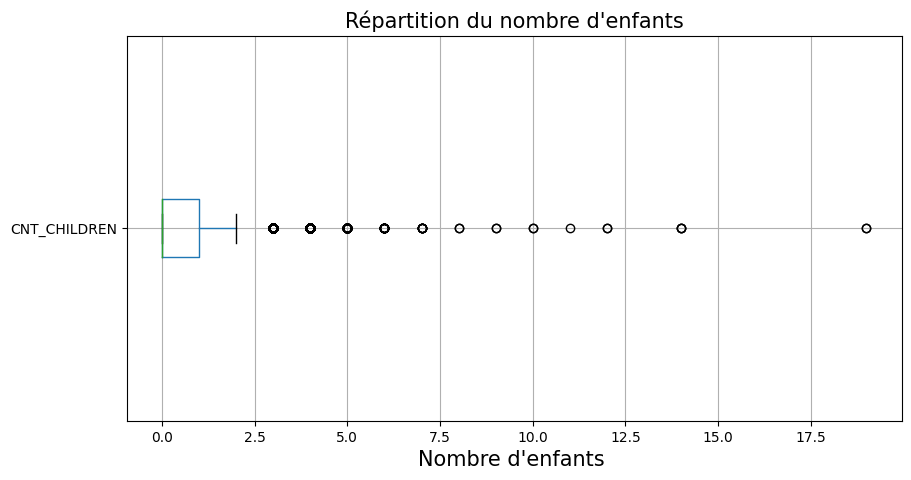

In [85]:
#Affichage de la répartition du nombre d'enfants par un boxplot
plt.figure(figsize=(10,5))
plt.title("Répartition du nombre d'enfants", fontsize=15)
df_app_train.boxplot(column="CNT_CHILDREN", vert=False, notch= False)
plt.xlabel("Nombre d'enfants ", fontsize=15) 
plt.show()

In [86]:
df_tmp=df_app_train.loc[df_app_train['CNT_CHILDREN']>3,:]
print("Il y a",df_tmp.shape[0], "valeurs >3")
print("Ce qui représente",round((df_tmp.shape[0]/len(df_app_train))*100,2),"% de df_app_train" )

Il y a 552 valeurs >3
Ce qui représente 0.18 % de df_app_train


In [87]:
#Remplacement des valeurs au dessus de 3 enfants par 3
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'CNT_CHILDREN']= np.nan
    i+=1
print(i, " remplacements ont étés fait")

552  remplacements ont étés fait


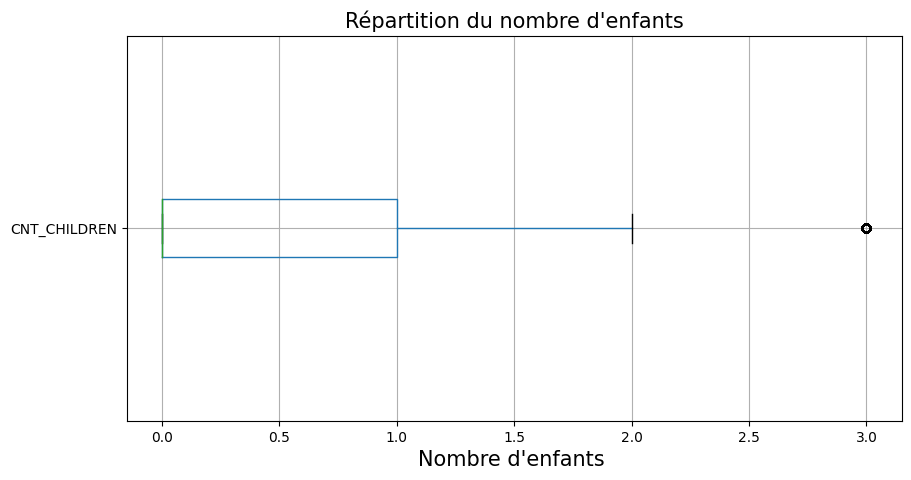

In [88]:
#Affichage de la répartition du nombre d'enfants par un boxplot
plt.figure(figsize=(10,5))
plt.title("Répartition du nombre d'enfants", fontsize=15)
df_app_train.boxplot(column="CNT_CHILDREN", vert=False, notch= False)
plt.xlabel("Nombre d'enfants ", fontsize=15) 
plt.show()

#####  3.3.5.2 AMT_INCOME_TOTAL

In [89]:
(df_app_train['AMT_INCOME_TOTAL']).describe()

count    3.055450e+05
mean     1.687142e+05
std      2.375879e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.485000e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

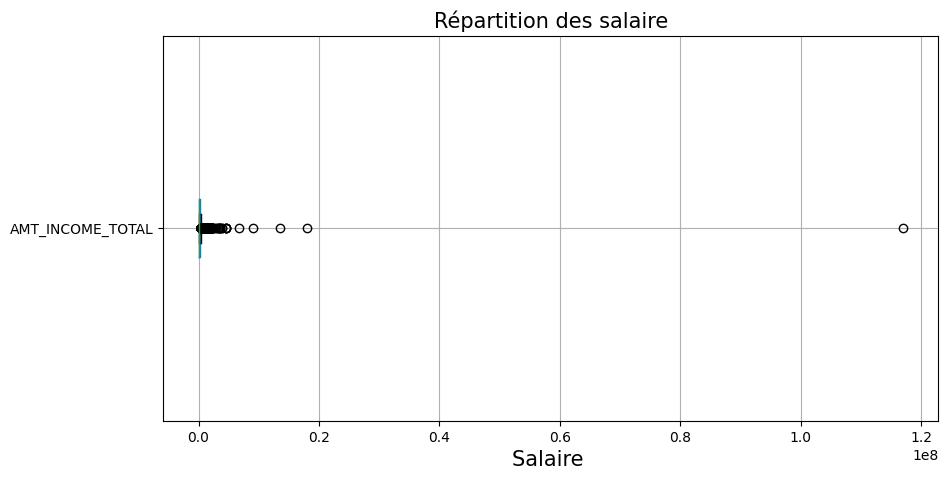

In [90]:
#Affichage de la répartition des salaires
plt.figure(figsize=(10,5))
plt.title("Répartition des salaire", fontsize=15)
df_app_train.boxplot(column="AMT_INCOME_TOTAL", vert=False, notch= False)
plt.xlabel("Salaire ", fontsize=15) 
plt.show()

In [91]:
df_tmp=df_app_train.loc[df_app_train['AMT_INCOME_TOTAL']>1e+08,:]
print("Il y a",df_tmp.shape[0], "valeurs >1e+08")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 1 valeurs >1e+08
Ce qui représente 0.0 % de df_app_train


In [92]:
#Remplacement des valeurs 
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'AMT_INCOME_TOTAL']= np.nan
    i+=1
print(i, " remplacements ont étés fait")

1  remplacements ont étés fait


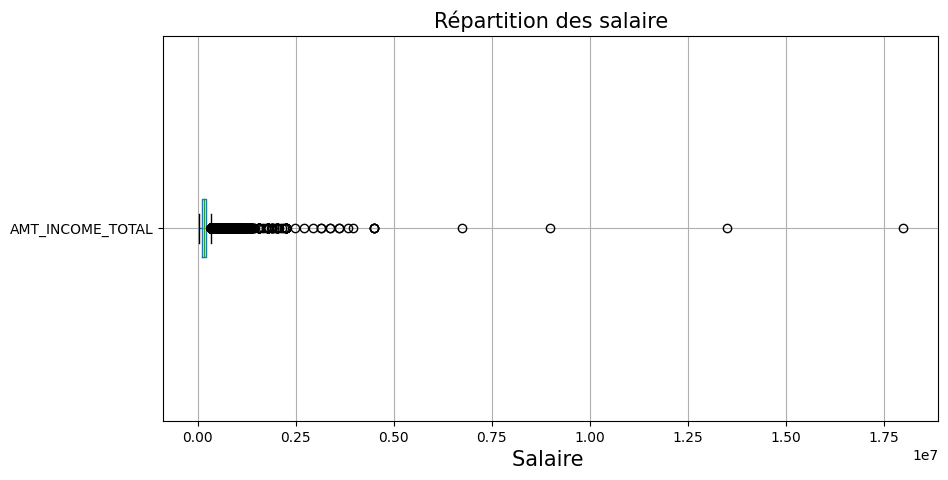

In [93]:
#Affichage de la répartition 
plt.figure(figsize=(10,5))
plt.title("Répartition des salaire", fontsize=15)
df_app_train.boxplot(column="AMT_INCOME_TOTAL", vert=False, notch= False)
plt.xlabel("Salaire ", fontsize=15) 
plt.show()

#####  3.3.5.3 DAYS_BIRTH

In [94]:
#Affichage des outliers en années
(df_app_train['DAYS_BIRTH'] / -365).describe()

count    305545.000000
mean         43.941442
std          11.953331
min          20.517808
25%          34.013699
50%          43.156164
75%          53.920548
max          69.120548
Name: DAYS_BIRTH, dtype: float64

#####  3.3.5.4 DAYS_EMPLOYED

In [95]:
#Affichage des outliers en années
(df_app_train['DAYS_EMPLOYED']/365).describe()

count    305545.000000
mean        174.853977
std         387.074195
min         -49.073973
25%          -7.564384
50%          -3.326027
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

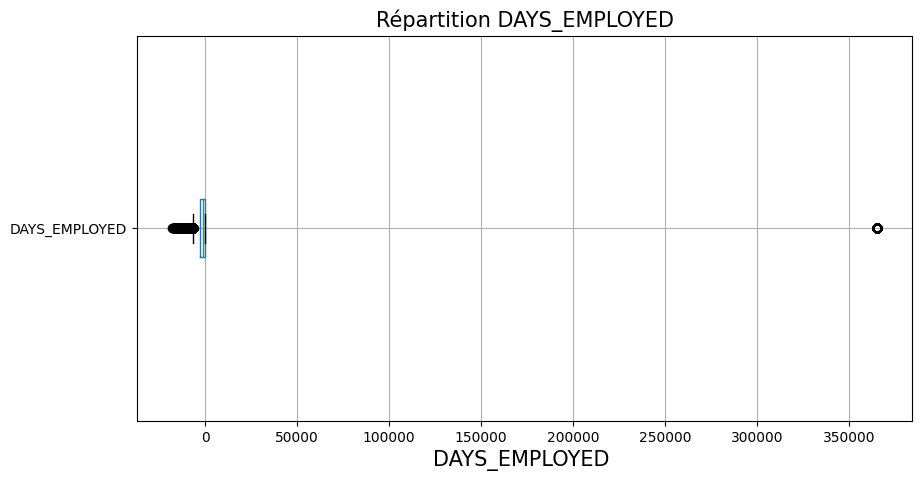

In [96]:
#Affichage de la répartition 
plt.figure(figsize=(10,5))
plt.title("Répartition DAYS_EMPLOYED", fontsize=15)
df_app_train.boxplot(column="DAYS_EMPLOYED", vert=False, notch= False)
plt.xlabel("DAYS_EMPLOYED ", fontsize=15) 
plt.show()

In [97]:
df_tmp=df_app_train.loc[df_app_train['DAYS_EMPLOYED']==365243,:]
print("Il y a",df_tmp.shape[0], "=365243")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 55026 =365243
Ce qui représente 18.01 % de df_app_train


In [98]:
df_tmp=df_app_train.loc[df_app_train['DAYS_EMPLOYED']>0,:]
print("Il y a",df_tmp.shape[0], ">0")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 55026 >0
Ce qui représente 18.01 % de df_app_train


In [99]:
mean=df_app_train['DAYS_EMPLOYED'].mean()
print(mean)
#La moyenne est faussée par 55026 valeurs = 365243 jours. Je calcul la moyenne pour les valeurs <=0


63821.70158896398


In [100]:
#Je calcul donc cette moyenne pour les valeurs <=0
df_tmp=df_app_train.loc[df_app_train['DAYS_EMPLOYED']<=0,:]
mean=df_tmp['DAYS_EMPLOYED'].mean()
print(mean)

-2384.886998590925


In [101]:
#Recalcul des index dont les valeurs sont à remplacer
df_tmp=df_app_train.loc[df_app_train['DAYS_EMPLOYED']>0,:]
print("Il y a",df_tmp.shape[0], ">0")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 55026 >0
Ce qui représente 18.01 % de df_app_train


In [102]:
#Remplacement des valeurs 
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'DAYS_EMPLOYED']= -2385 #Récupération de la moyenne calculée plus haut
    i+=1
print(i, " remplacements ont étés fait")

55026  remplacements ont étés fait


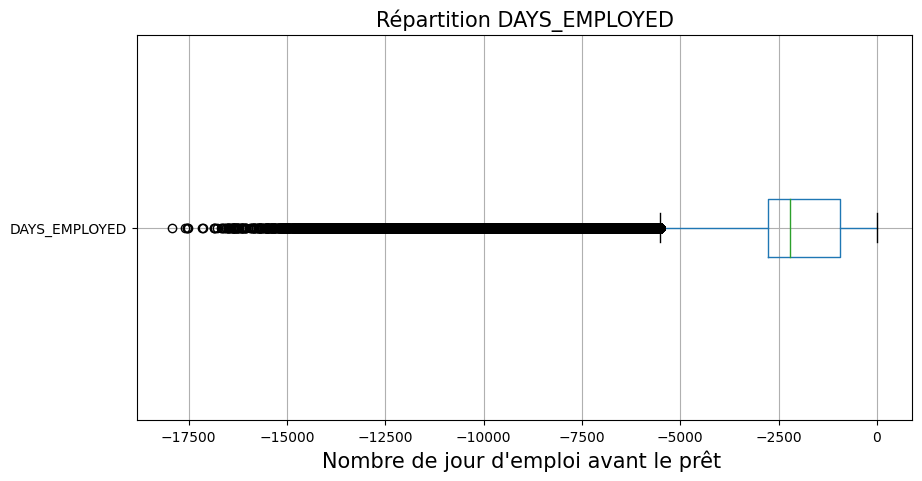

In [103]:
#Affichage de la répartition 
plt.figure(figsize=(10,5))
plt.title("Répartition DAYS_EMPLOYED", fontsize=15)
df_app_train.boxplot(column="DAYS_EMPLOYED", vert=False, notch= False)
plt.xlabel("Nombre de jour d'emploi avant le prêt ", fontsize=15) 
plt.show()

In [104]:
#Affichage des outliers en années
(df_app_train['DAYS_EMPLOYED']/365).describe()

count    305545.000000
mean         -6.533993
std           5.802304
min         -49.073973
25%          -7.564384
50%          -6.082192
75%          -2.556164
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

#####  3.3.5.5 OWN_CAR_AGE

In [105]:
#Affichage des outliers en années
(df_app_train['OWN_CAR_AGE']).describe()

count    305545.000000
mean         12.060337
std           6.960117
min           0.000000
25%          12.061091
50%          12.061091
75%          12.061091
max          91.000000
Name: OWN_CAR_AGE, dtype: float64

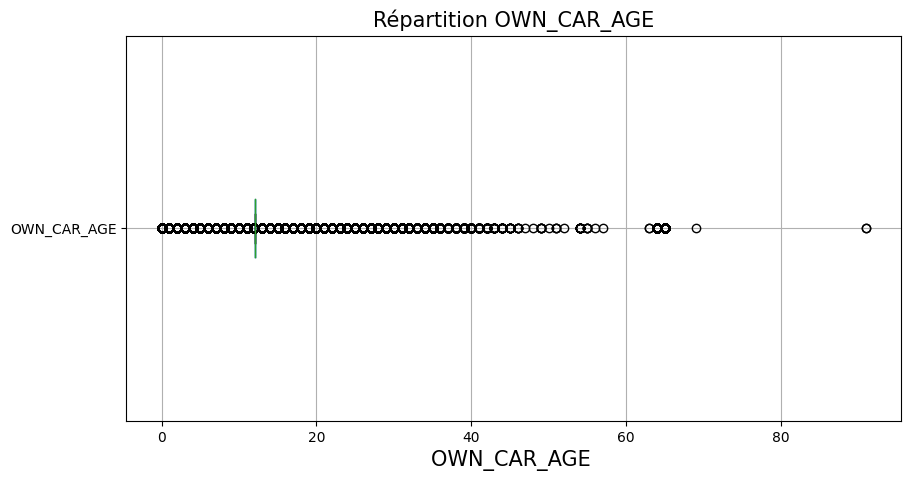

In [106]:
#Affichage de la répartition 
plt.figure(figsize=(10,5))
plt.title("Répartition OWN_CAR_AGE", fontsize=15)
df_app_train.boxplot(column="OWN_CAR_AGE", vert=False, notch= False)
plt.xlabel("OWN_CAR_AGE ", fontsize=15) 
plt.show()

#####  3.3.5.6 CNT_FAM_MEMBERS

In [107]:
#Affichage des outliers en années
(df_app_train['CNT_FAM_MEMBERS']).describe()

count    305545.000000
mean          2.152986
std           0.910665
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: CNT_FAM_MEMBERS, dtype: float64

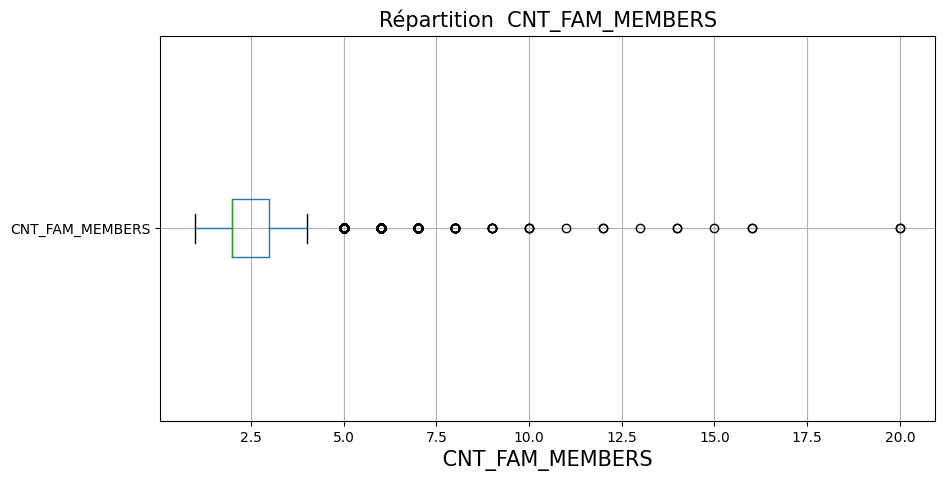

In [108]:
#Affichage de la répartition 
plt.figure(figsize=(10,5))
plt.title("Répartition  CNT_FAM_MEMBERS", fontsize=15)
df_app_train.boxplot(column= "CNT_FAM_MEMBERS", vert=False, notch= False)
plt.xlabel(" CNT_FAM_MEMBERS ", fontsize=15) 
plt.show()

In [109]:
df_tmp=df_app_train.loc[df_app_train['CNT_FAM_MEMBERS']>5,:]
print("Il y a",df_tmp.shape[0], ">5")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 527 >5
Ce qui représente 0.17 % de df_app_train


In [110]:
#Remplacement des valeurs 
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'CNT_FAM_MEMBERS']= np.nan
    i+=1
print(i, " remplacements ont étés fait")

527  remplacements ont étés fait


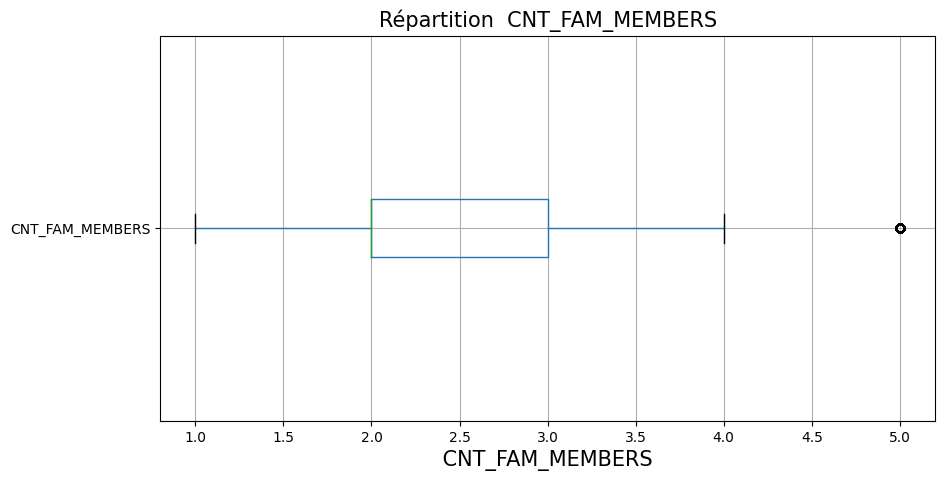

In [111]:
#Affichage de la répartition 
plt.figure(figsize=(10,5))
plt.title("Répartition  CNT_FAM_MEMBERS", fontsize=15)
df_app_train.boxplot(column= "CNT_FAM_MEMBERS", vert=False, notch= False)
plt.xlabel(" CNT_FAM_MEMBERS ", fontsize=15) 
plt.show()

#####  3.3.5.7 OBS_60_CNT_SOCIAL_CIRCLE

In [112]:
#Affichage des outliers en années
(df_app_train['OBS_60_CNT_SOCIAL_CIRCLE']).describe()

count    305545.000000
mean          1.405937
std           2.380499
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         344.000000
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64

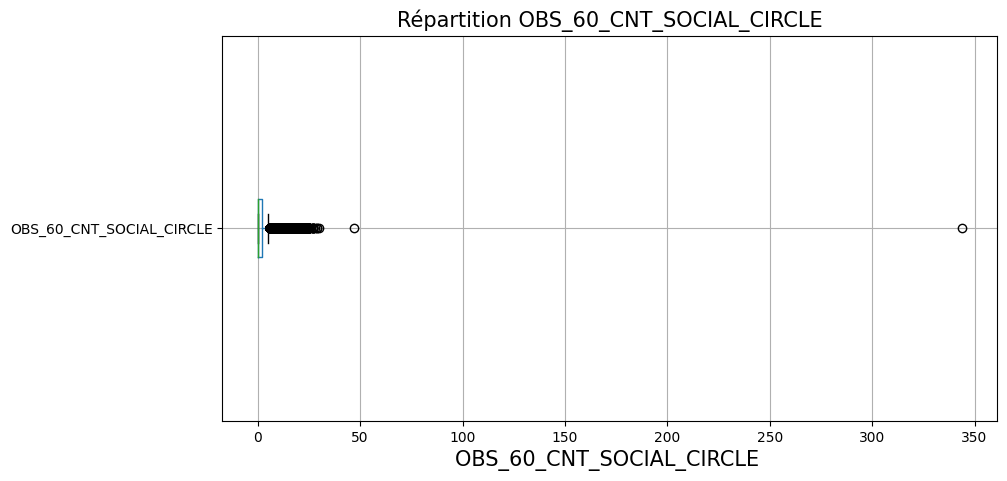

In [113]:
#Affichage de la répartition 
plt.figure(figsize=(10,5))
plt.title("Répartition OBS_60_CNT_SOCIAL_CIRCLE", fontsize=15)
df_app_train.boxplot(column= "OBS_60_CNT_SOCIAL_CIRCLE", vert=False, notch= False)
plt.xlabel("OBS_60_CNT_SOCIAL_CIRCLE ", fontsize=15) 
plt.show()

In [114]:
df_tmp=df_app_train.loc[df_app_train['OBS_60_CNT_SOCIAL_CIRCLE']>30,:]
print("Il y a",df_tmp.shape[0], ">30")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 2 >30
Ce qui représente 0.0 % de df_app_train


In [115]:
#Remplacement des valeurs 
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'OBS_60_CNT_SOCIAL_CIRCLE']= np.nan
    i+=1
print(i, " remplacements ont étés fait")

2  remplacements ont étés fait


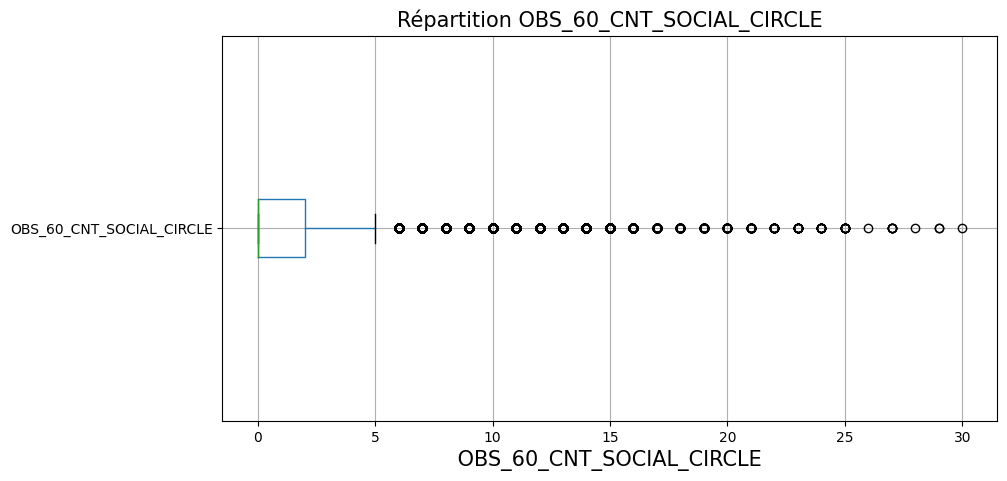

In [116]:
#Affichage de la répartition 
plt.figure(figsize=(10,5))
plt.title("Répartition OBS_60_CNT_SOCIAL_CIRCLE", fontsize=15)
df_app_train.boxplot(column= "OBS_60_CNT_SOCIAL_CIRCLE", vert=False, notch= False)
plt.xlabel(" OBS_60_CNT_SOCIAL_CIRCLE ", fontsize=15) 
plt.show()

#####  3.3.5.8 DEF_60_CNT_SOCIAL_CIRCLE

In [117]:
#Affichage des outliers en années
(df_app_train['DEF_60_CNT_SOCIAL_CIRCLE']).describe()

count    305545.000000
mean          0.100093
std           0.362380
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          24.000000
Name: DEF_60_CNT_SOCIAL_CIRCLE, dtype: float64

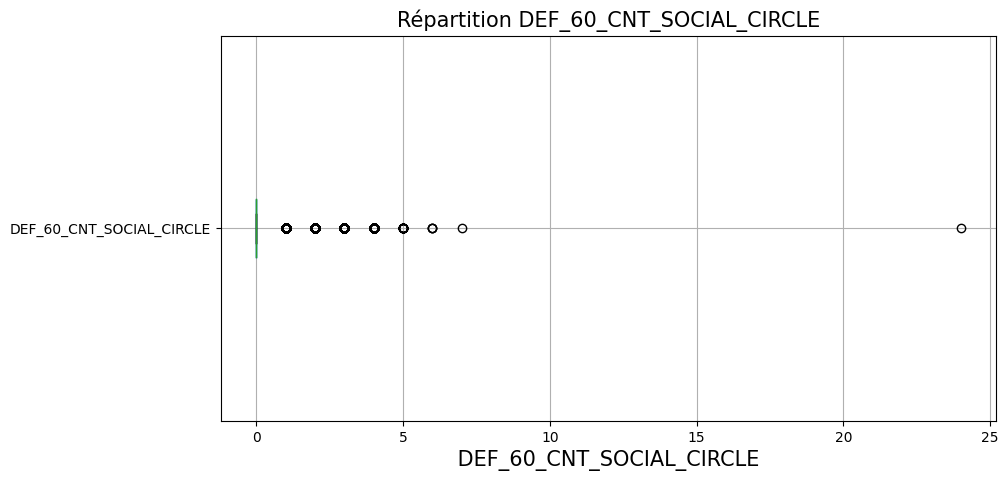

In [118]:
#Affichage de la répartition 
plt.figure(figsize=(10,5))
plt.title("Répartition DEF_60_CNT_SOCIAL_CIRCLE", fontsize=15)
df_app_train.boxplot(column= "DEF_60_CNT_SOCIAL_CIRCLE", vert=False, notch= False)
plt.xlabel(" DEF_60_CNT_SOCIAL_CIRCLE ", fontsize=15) 
plt.show()

In [119]:
df_tmp=df_app_train.loc[df_app_train['DEF_60_CNT_SOCIAL_CIRCLE']>10,:]
print("Il y a",df_tmp.shape[0], ">10")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 1 >10
Ce qui représente 0.0 % de df_app_train


In [120]:
#Remplacement des valeurs 
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'DEF_60_CNT_SOCIAL_CIRCLE']= np.nan
    i+=1
print(i, " remplacements ont étés fait")

1  remplacements ont étés fait


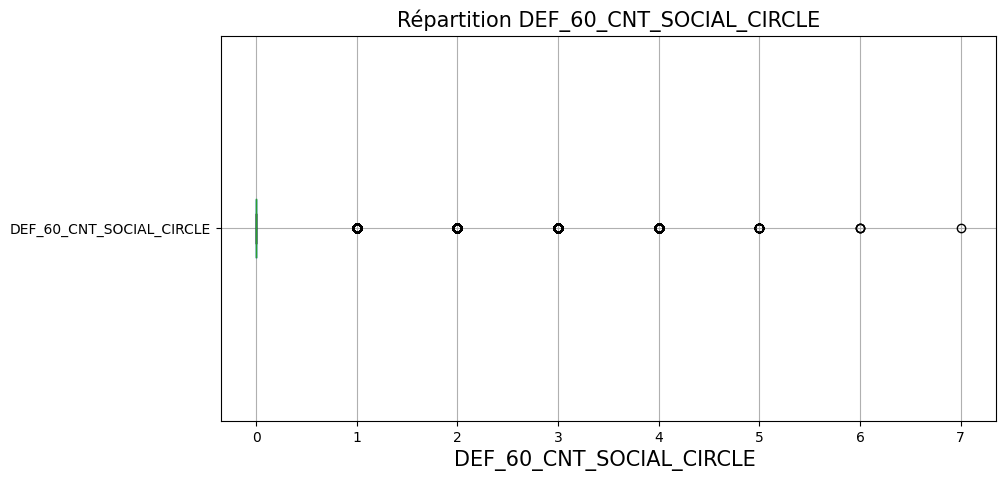

In [121]:
#Affichage de la répartition 
plt.figure(figsize=(10,5))
plt.title("Répartition DEF_60_CNT_SOCIAL_CIRCLE", fontsize=15)
df_app_train.boxplot(column= "DEF_60_CNT_SOCIAL_CIRCLE", vert=False, notch= False)
plt.xlabel("DEF_60_CNT_SOCIAL_CIRCLE ", fontsize=15) 
plt.show()

#####  3.3.5.9 OBS_30_CNT_SOCIAL_CIRCLE

In [122]:
#Affichage des outliers en années
(df_app_train['OBS_30_CNT_SOCIAL_CIRCLE']).describe()

count    305545.000000
mean          1.422877
std           2.401671
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         348.000000
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64

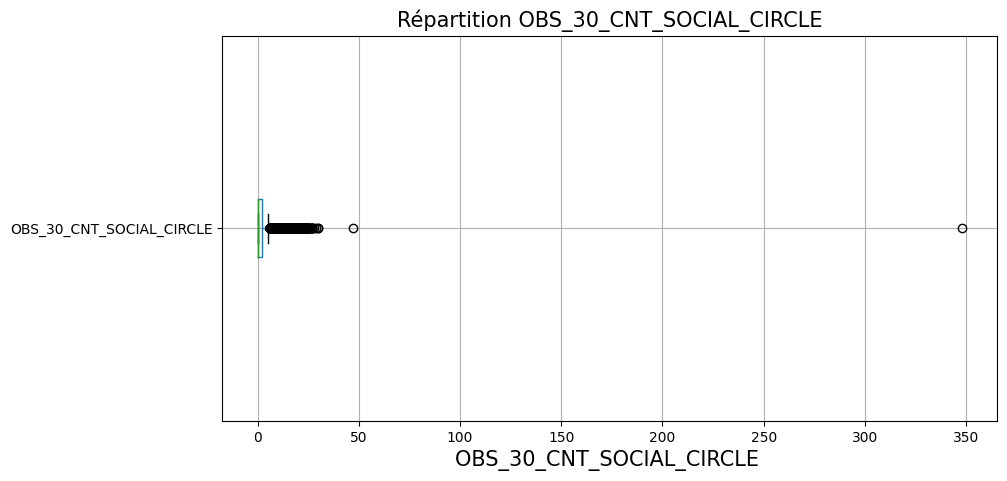

In [123]:
#Affichage de la répartition 
plt.figure(figsize=(10,5))
plt.title("Répartition OBS_30_CNT_SOCIAL_CIRCLE", fontsize=15)
df_app_train.boxplot(column= "OBS_30_CNT_SOCIAL_CIRCLE", vert=False, notch= False)
plt.xlabel("OBS_30_CNT_SOCIAL_CIRCLE ", fontsize=15) 
plt.show()

In [124]:
df_tmp=df_app_train.loc[df_app_train['OBS_30_CNT_SOCIAL_CIRCLE']>30,:]
print("Il y a",df_tmp.shape[0], ">30")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 2 >30
Ce qui représente 0.0 % de df_app_train


In [125]:
#Remplacement des valeurs 
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'OBS_30_CNT_SOCIAL_CIRCLE']= np.nan
    i+=1
print(i, " remplacements ont étés fait")

2  remplacements ont étés fait


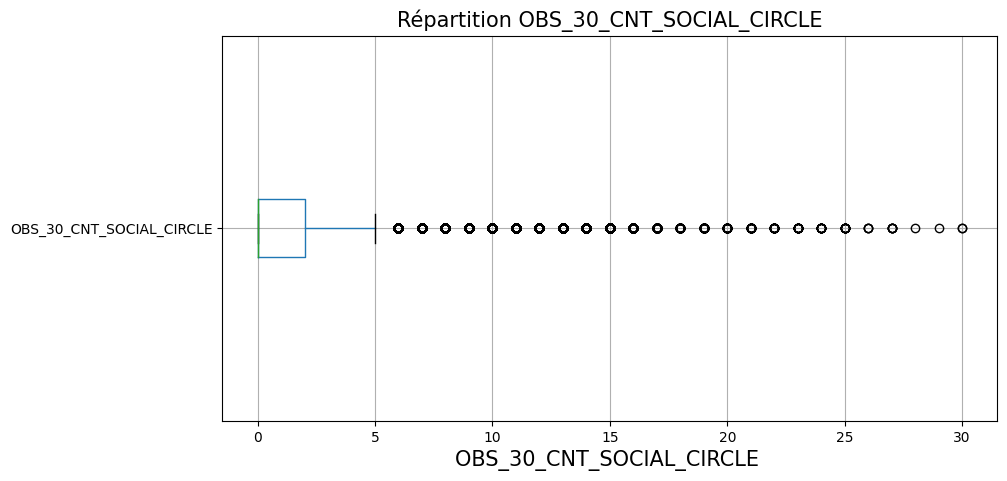

In [126]:
#Affichage de la répartition 
plt.figure(figsize=(10,5))
plt.title("Répartition OBS_30_CNT_SOCIAL_CIRCLE", fontsize=15)
df_app_train.boxplot(column= "OBS_30_CNT_SOCIAL_CIRCLE", vert=False, notch= False)
plt.xlabel("OBS_30_CNT_SOCIAL_CIRCLE ", fontsize=15) 
plt.show()

#####  3.3.5.10 DEF_30_CNT_SOCIAL_CIRCLE

In [127]:
#Affichage des outliers en années
(df_app_train['DEF_30_CNT_SOCIAL_CIRCLE']).describe()

count    305545.000000
mean          0.143458
std           0.446752
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          34.000000
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64

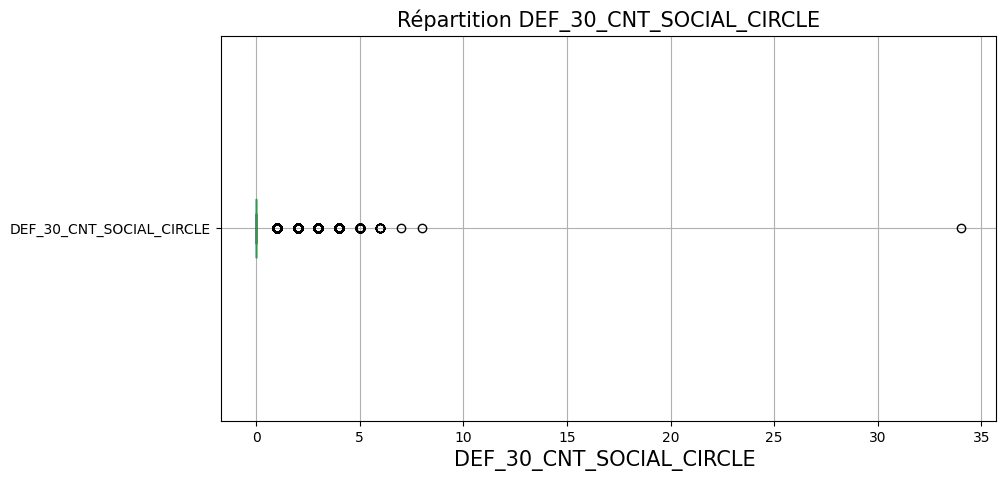

In [128]:
#Affichage de la répartition 
plt.figure(figsize=(10,5))
plt.title("Répartition DEF_30_CNT_SOCIAL_CIRCLE", fontsize=15)
df_app_train.boxplot(column= "DEF_30_CNT_SOCIAL_CIRCLE", vert=False, notch= False)
plt.xlabel("DEF_30_CNT_SOCIAL_CIRCLE ", fontsize=15) 
plt.show()

In [129]:
df_tmp=df_app_train.loc[df_app_train['DEF_30_CNT_SOCIAL_CIRCLE']>10,:]
print("Il y a",df_tmp.shape[0], ">10")
print("Ce qui représente",round((df_tmp.shape[0]/(len(df_app_train))*100),2),"% de df_app_train" )

Il y a 1 >10
Ce qui représente 0.0 % de df_app_train


In [130]:
#Remplacement des valeurs 
i=0
for index in df_tmp.index:
    df_app_train.loc[index, 'DEF_30_CNT_SOCIAL_CIRCLE']= np.nan
    i+=1
print(i, " remplacements ont étés fait")

1  remplacements ont étés fait


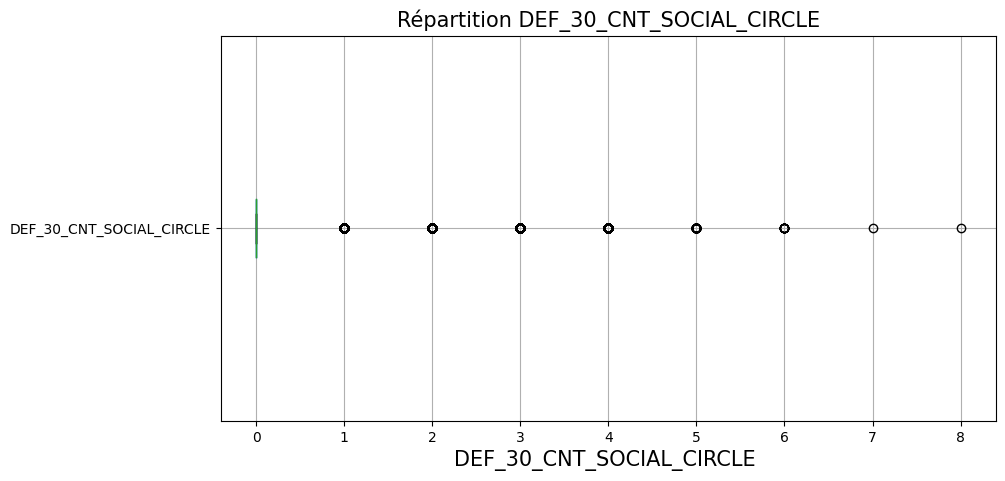

In [131]:
#Affichage de la répartition 
plt.figure(figsize=(10,5))
plt.title("Répartition DEF_30_CNT_SOCIAL_CIRCLE", fontsize=15)
df_app_train.boxplot(column= "DEF_30_CNT_SOCIAL_CIRCLE", vert=False, notch= False)
plt.xlabel("DEF_30_CNT_SOCIAL_CIRCLE ", fontsize=15) 
plt.show()

#####  3.3.5.11 Variables catégorielles

In [132]:
df_app_train.describe(include = 'object')

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE
count,305545,305545,305545,305545,305545,305545,305545,305545,305545,305545,305545,305545
unique,2,3,2,2,8,5,5,6,19,3,3,58
top,Cash loans,F,N,Y,Working,Secondary / secondary special,Married,House / apartment,Not_defined,2,2,Business Entity Type 3
freq,277620,201098,201510,211884,157798,217187,195277,271158,95763,225559,228042,67517


#####  3.3.3.x xxxxxx

In [133]:
####  3.3.3.2 df_application_test_c1

In [134]:
print("df_app_test")
display(df_app_test.describe(include=['object', 'float', 'int']))
print("df_bur")
display(df_bur.describe(include=['object', 'float', 'int']))
print("df_bur_bal")
display(df_bur_bal.describe(include=['object', 'float', 'int']))
print("df_credit_card_bal")
display(df_credit_card_bal.describe(include=['object', 'float', 'int']))
print("df_installments_payments_c1")
display(df_instal_pay.describe(include=['object', 'float', 'int']))
print("df_POS_CASH_bal")
display(df_POS_CASH_bal.describe(include=['object', 'float', 'int']))
print("df_previous_app")
display(df_previous_app.describe(include=['object', 'float', 'int']))
print("df_sample_sub_c1")
display(df_sample_sub.describe(include=['object', 'float', 'int']))

df_app_test


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744,48744,48744,48744,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,47833,48744,48744,48744,48744,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,16432.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,33139,48744.000000,48744.000000,48744.000000,48744,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744,28212.000000,48736.000000,40076.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,15947,25125,26120.000000,24851,26535,48715.000000,48715.000000,48715.000000,48715.000000,48744.000000,48744.0,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.0,48744.000000,48744.0,48744.0,48744.0,48744.0,48744.0,48744.0,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
unique,NaN,2,2,2,2,NaN,NaN,NaN,NaN,NaN,7,7,5,5,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,7,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

df_bur


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1716428,1716428,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1716428,1.716428e+06,4.896370e+05
unique,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN
top,NaN,NaN,Closed,currency 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer credit,NaN,NaN
freq,NaN,NaN,1079273,1715020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1251615,NaN,NaN
mean,2.782149e+05,5.924434e+06,NaN,NaN,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,NaN,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,NaN,NaN,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,NaN,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,NaN,NaN,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,NaN,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,NaN,NaN,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,NaN,NaN,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,NaN,NaN,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,NaN,-3.300000e+01,1.350000e+04


df_bur_bal


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
count,2.729992e+07,2.729992e+07,27299925
unique,NaN,NaN,8
top,NaN,NaN,C
freq,NaN,NaN,13646993
mean,6.036297e+06,-3.074169e+01,NaN
std,4.923489e+05,2.386451e+01,NaN
min,5.001709e+06,-9.600000e+01,NaN
25%,5.730933e+06,-4.600000e+01,NaN
50%,6.070821e+06,-2.500000e+01,NaN
75%,6.431951e+06,-1.100000e+01,NaN


df_credit_card_bal


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.072324e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3840312,3.840312e+06,3.840312e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3698436,NaN,NaN
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,1.028054e+04,7.588857e+03,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,NaN,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,3.607808e+04,3.200599e+04,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,NaN,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.523700e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.702700e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,NaN,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,9.000000e+03,6.750000e+03,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,NaN,0.000000e+00,0.000000e+00


df_installments_payments_c1


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


df_POS_CASH_bal


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,10001358,1.000136e+07,1.000136e+07
unique,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,9151119,NaN,NaN
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,NaN,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,NaN,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,NaN,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,NaN,0.000000e+00,0.000000e+00


df_previous_app


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1670214,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1670214,1.670214e+06,1670214,1.670214e+06,774370.000000,5951.000000,5951.000000,1670214,1670214,1.670214e+06,1670214,1670214,849809,1670214,1670214,1670214,1670214,1670214,1.670214e+06,1670214,1.297984e+06,1670214,1669868,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
unique,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,7,NaN,2,NaN,NaN,NaN,NaN,25,4,NaN,4,9,7,4,28,5,3,8,NaN,11,NaN,5,17,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,NaN,NaN,NaN,NaN,NaN,TUESDAY,NaN,Y,NaN,NaN,NaN,NaN,XAP,Approved,NaN,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,POS,XNA,Credit and cash offices,NaN,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,747553,NaN,NaN,NaN,NaN,NaN,255118,NaN,1661739,NaN,NaN,NaN,NaN,922661,1036781,NaN,1033552,1353093,508970,1231261,950809,691011,1063666,719968,NaN,855720,NaN,517215,285990,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.923089e+06,2.783572e+05,NaN,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,NaN,1.248418e+01,NaN,9.964675e-01,0.079637,0.188357,0.773503,NaN,NaN,-8.806797e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.139511e+02,NaN,1.605408e+01,NaN,NaN,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,NaN,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,NaN,3.334028e+00,NaN,5.932963e-02,0.107823,0.087671,0.100879,NaN,NaN,7.790997e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.127443e+03,NaN,1.456729e+01,NaN,NaN,88916.115833,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,-0.000015,0.034781,0.373150,NaN,NaN,-2.922000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000e+00,NaN,0.000000e+00,NaN,NaN,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,NaN,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,NaN,1.000000e+01,NaN,1.000000e+00,0.000000,0.160716,0.715645,NaN,NaN,-1.300000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000e+00,NaN,6.000000e+00,NaN,NaN,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,NaN,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,NaN,1.200000e+01,NaN,1.000000e+00,0.051605,0.189122,0.835095,NaN,NaN,-5.810000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000e+00,NaN,1.200000e+01,NaN,NaN,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,NaN,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,NaN,1.500000e+01,NaN,1.000000e+00,0.108909,0.193330,0.852537,NaN,NaN,-2.800000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.200000e+01,NaN,2.400000e+01,NaN,NaN,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000


df_sample_sub_c1


,SK_ID_CURR,TARGET
count,48744.000000,48744.0
mean,277796.676350,0.5
std,103169.547296,0.0
min,100001.000000,0.5
25%,188557.750000,0.5
50%,277549.000000,0.5
75%,367555.500000,0.5
max,456250.000000,0.5


### <a name="C336"> 3.3.6 "NaN" générés par le traitement des Outliers</a> 

In [135]:
affichage_manquants(df_app_train)

,colonne,quantite_manquante,% manquant
0,CNT_CHILDREN,552,0.18
1,CNT_FAM_MEMBERS,527,0.17
2,OBS_30_CNT_SOCIAL_CIRCLE,2,0.00
3,OBS_60_CNT_SOCIAL_CIRCLE,2,0.00
4,AMT_INCOME_TOTAL,1,0.00
5,DEF_30_CNT_SOCIAL_CIRCLE,1,0.00
6,DEF_60_CNT_SOCIAL_CIRCLE,1,0.00


In [136]:
#Soit suppression des lignes vides : axis =0 soit colonnes vides axis = 1
df_app_train_full = df_app_train.dropna(axis=0)

In [137]:
print("Suppression de ", df_app_train.shape[0]-df_app_train_full.shape[0], "lignes")
print("soit ",((df_app_train.shape[0]-df_app_train_full.shape[0])/df_app_train.shape[0])*100," %")
print("il reste :", df_app_train_full.shape[0]," lignes")

Suppression de  555 lignes
soit  0.18164263856387766  %
il reste : 304990  lignes


In [138]:
#Création d'une copie pour retrouver le nom d'origine
df_app_train=df_app_train_full.copy()

In [139]:
affichage_manquants(df_app_train)

,colonne,quantite_manquante,% manquant


### <a name="C337"> 3.3.7 Bilan du nettoyage</a> 

In [140]:
df_app_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304990 entries, 0 to 307510
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   304990 non-null  int64  
 1   TARGET                       304990 non-null  int64  
 2   NAME_CONTRACT_TYPE           304990 non-null  object 
 3   CODE_GENDER                  304990 non-null  object 
 4   FLAG_OWN_CAR                 304990 non-null  object 
 5   FLAG_OWN_REALTY              304990 non-null  object 
 6   CNT_CHILDREN                 304990 non-null  float64
 7   AMT_INCOME_TOTAL             304990 non-null  float64
 8   AMT_CREDIT                   304990 non-null  float64
 9   AMT_ANNUITY                  304990 non-null  float64
 10  AMT_GOODS_PRICE              304990 non-null  float64
 11  NAME_INCOME_TYPE             304990 non-null  object 
 12  NAME_EDUCATION_TYPE          304990 non-null  object 
 13 

In [141]:
#from preprocessing import *
#df_app_train=pd.read_csv('application_train.csv')
#df_app_train=fct_preprocessing(df_app_train)

In [142]:
#Passage de SK_ID_CURR en index (pour ne pas perdre l'information et éviter qu'il ne se trouve dans les modèles)
df_app_train.set_index('SK_ID_CURR', inplace = True)

In [143]:
df_app_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304990 entries, 100002 to 456255
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       304990 non-null  int64  
 1   NAME_CONTRACT_TYPE           304990 non-null  object 
 2   CODE_GENDER                  304990 non-null  object 
 3   FLAG_OWN_CAR                 304990 non-null  object 
 4   FLAG_OWN_REALTY              304990 non-null  object 
 5   CNT_CHILDREN                 304990 non-null  float64
 6   AMT_INCOME_TOTAL             304990 non-null  float64
 7   AMT_CREDIT                   304990 non-null  float64
 8   AMT_ANNUITY                  304990 non-null  float64
 9   AMT_GOODS_PRICE              304990 non-null  float64
 10  NAME_INCOME_TYPE             304990 non-null  object 
 11  NAME_EDUCATION_TYPE          304990 non-null  object 
 12  NAME_FAMILY_STATUS           304990 non-null  object 

In [144]:
STOP

NameError: name 'STOP' is not defined

# 4 Analyses

## <a name="C41">4.1 Analyses multivarées</a>

### <a name="C411">4.1.1 Variables numériques </a>

#### <a name="C4111">4.1.1.1 Corrélation </a>

In [ ]:
correlation(df_app_train)

In [ ]:
# Recherche de la corrélation avec la TARGET
correlations = df_app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

##### <a name="C41111">4.1.1.1.1 DAYS_BIRTH vs TARGET </a>

In [ ]:
# Passage en positif des jours pour analyser la corrélation avec la target
df_app_train['DAYS_BIRTH'].corr(-df_app_train['TARGET'])

In [ ]:
plt.figure(figsize = (10, 8))

# Affichage de la répartition des ages quand le prêt est remboursé
ax=sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'target == 0')

# Affichage de la répartition des ages quand le prêt n'est pas remboursé
sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'target == 1')

#affichage de la légende
ax.legend(loc="upper right")

# Labeling  du graphe
plt.xlabel('Age (année)'); plt.ylabel('Densité'); plt.title('Distribution des Ages');


In [ ]:
# Mise des targets et age dans un nouveau dataframe
age_data = df_app_train[['TARGET', 'DAYS_BIRTH']]
age_data['DAYS_BIRTH']=-age_data['DAYS_BIRTH']
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Classification des ages dans un interval
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

In [ ]:
# Regroupement par interval et calcul des moyennes
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

In [ ]:
plt.figure(figsize = (8, 8))

# Affichage en barplot des interval et les moyennes
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'], color='coral')

# labélisation du graphe
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Défaut de paiement (%)')
plt.title('Défaut de paiement par groupe age');

##### <a name="C41112">4.1.1.1.2 DAYS_EMPLOYED vs TARGET </a>

In [ ]:
plt.figure(figsize = (10, 8))

# Affichage de la répartition des ages quand le prêt est remboursé
ax=sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 0, 'DAYS_EMPLOYED'] / -365, label = 'target == 0')

# Affichage de la répartition des ages quand le prêt n'est pas remboursé
sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 1, 'DAYS_EMPLOYED'] / -365, label = 'target == 1')

#affichage de la légende
ax.legend(loc="upper right")

# Labeling  du graphe
plt.xlabel('Age (année)'); plt.ylabel('Densité'); plt.title('Distribution des jours embauche');

##### <a name="C41113">4.1.1.1.3 SOURCE_EXT vs TARGET </a>

In [ ]:
# Extraction des variables et affichage de la corrélation
ext_data = df_app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

In [ ]:
plt.figure(figsize = (8, 6))

# Heatmap
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, square=True, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap de correlation');

In [ ]:
plt.figure(figsize = (10, 12))



# Affichage de la distribution des 3 source par retard ou non de paiement
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
        
    # Séparation des sources dans un subplot
    plt.subplot(3, 1, i + 1)
    # paiement OK
    ax=sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 0, source], label = 'target == 0')
    
    # paiement NOK
    sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label
    plt.title('Distribution de %s par TARGET' % source)
    plt.xlabel('%s' % source); plt.ylabel('Densité');

   #affichage de la légende
    ax.legend(loc="upper right")
    
plt.tight_layout(h_pad = 2.5)

##### <a name="C41114">4.1.1.1.4 AMT_X vs AMT_X </a>

In [ ]:
# Extraction des variables et affichage de la corrélation
ext_data = df_app_train[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

In [ ]:
plt.figure(figsize = (8, 6))

# Heatmap
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -1, annot = True, vmax = 1)
plt.title('Heatmap de correlation');

In [ ]:
sns.scatterplot(x="AMT_GOODS_PRICE",y="AMT_CREDIT",data=df_app_train)

In [ ]:
sns.scatterplot(x="AMT_ANNUITY",y="AMT_CREDIT",data=df_app_train)

##### <a name="C41115">4.1.1.1.5 OBS_60/30_CNT_SOCIAL_CIRCLE vs DEF_60/30_CNT_SOCIAL_CIRCLE </a>

In [ ]:
# Extraction des variables et affichage de la corrélation
ext_data = df_app_train[['OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

In [ ]:
plt.figure(figsize = (8, 6))

# Heatmap
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -1, annot = True, vmax = 1)
plt.title('Heatmap de correlation');

In [ ]:
df_tmp=df_app_train.loc[:,['OBS_60_CNT_SOCIAL_CIRCLE','OBS_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE', 'TARGET']]
sns.pairplot(df_tmp, hue='TARGET')

##### <a name="C41116">4.1.1.1.6 DAYS_BIRTH vs CNT_CHILDREN vs DAYS_EMPLOYED vs CNT_FAM_MEMBERS vs EXT_SOURCE_1 vs EXT_SOURCE_3 </a>

In [ ]:
# Extraction des variables et affichage de la corrélation
ext_data = df_app_train[['DAYS_BIRTH', 'CNT_CHILDREN','DAYS_EMPLOYED','CNT_FAM_MEMBERS', 'EXT_SOURCE_1','EXT_SOURCE_3']]
ext_data['DAYS_BIRTH']=-ext_data['DAYS_BIRTH']
ext_data_corrs = ext_data.corr()
ext_data_corrs

In [ ]:
plt.figure(figsize = (8, 6))

# Heatmap
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -1, annot = True, vmax = 1)
plt.title('Heatmap de correlation');

In [ ]:
df_tmp = df_app_train[[ 'DAYS_BIRTH','CNT_CHILDREN']]
df_tmp['DAYS_BIRTH']=df_tmp['DAYS_BIRTH']/-365
sns.scatterplot(x="DAYS_BIRTH",y="CNT_CHILDREN",data=df_tmp)

In [ ]:
sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
x=df_tmp['DAYS_BIRTH']
y=df_tmp['CNT_CHILDREN']
for (yt, yp) in zip(list(x), list(y)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += 10
    else:
        sizes[(yt, yp)] = 10

keys = sizes.keys()

plt.scatter(
        [k[0] for k in keys], # (abscisse)
        [k[1] for k in keys], #  (ordonnee)
        s=[sizes[k] for k in keys], # taille du marqueur
        color='coral', alpha =0.8)
plt.xlabel('DAYS_BIRTH')
plt.ylabel('CNT_CHILDREN')
plt.show()

In [ ]:
sns.scatterplot(x="CNT_FAM_MEMBERS",y="CNT_CHILDREN",data=df_app_train)

In [ ]:
sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
x=df_app_train['CNT_FAM_MEMBERS']
y=df_app_train['CNT_CHILDREN']
for (yt, yp) in zip(list(x), list(y)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += 0.05
    else:
        sizes[(yt, yp)] = 0.05

keys = sizes.keys()

plt.scatter(
        [k[0] for k in keys], #  (abscisse)
        [k[1] for k in keys], #  (ordonnee)
        s=[sizes[k] for k in keys], # taille du marqueur
        color='coral', alpha =0.8)
plt.xlabel('CNT_FAM_MEMBERS')
plt.ylabel('CNT_CHILDREN')
plt.show()

In [ ]:
#correlation(df_app_test)

In [ ]:
#correlation(df_bur)

In [ ]:
#correlation(df_bur_bal)

In [ ]:
#correlation(df_credit_card_bal)

In [ ]:
#correlation(df_instal_pay)

In [ ]:
#correlation(df_POS_CASH_bal)

In [ ]:
#correlation(df_previous_app)

In [ ]:
#correlation(df_sample_sub)

### <a name="C412">4.1.2 Variables catégorielles (méthode CHI2)</a>

In [ ]:
df_app_train.describe(include = 'object')

In [ ]:
#Création d'une dataframe ne contenant que les objets et transformation de la target en objet
df_app_train_obj = df_app_train.select_dtypes(include=['object'] )
df_app_train_obj["TARGET"]=df_app_train["TARGET"]
df_app_train_obj = df_app_train_obj.astype({"TARGET": str})
df_app_train_obj.info()

#### <a name="C4121">4.1.2.1 TARGET vs CODE_GENDER </a>    

In [ ]:
chi02(df_app_train_obj, "TARGET","CODE_GENDER")

#### <a name="C4122">4.1.2.2 TARGET vs NAME_INCOME_TYPE </a>   

In [ ]:
chi02(df_app_train_obj, "TARGET","NAME_INCOME_TYPE")

#### <a name="C4123">4.1.2.3 TARGET vs NAME_EDUCATION_TYPE </a>   

In [ ]:
chi02(df_app_train_obj, "TARGET","NAME_EDUCATION_TYPE")

#### <a name="C4124">4.1.2.4 TARGET vs NAME_FAMILY_STATUS </a>   

In [ ]:
chi02(df_app_train_obj, "TARGET","NAME_FAMILY_STATUS")

#### <a name="C4125">4.1.2.5 TARGET vs OCCUPTION_TYPE </a>   

In [ ]:
chi02(df_app_train_obj, "TARGET","OCCUPATION_TYPE")

In [ ]:
X='TARGET'
Y='OCCUPATION_TYPE'
df=df_app_train_obj.copy()
    
cont = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
display(cont)
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(df)
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = round(measure/xi_n,2)
#sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
#plt.show()
plt.figure(figsize=(20,20))
sns.heatmap(table.iloc[:-1,:-1],annot=True)
plt.show()

#### <a name="C4126">4.1.2.6 TARGET vs NAME_HOUSING_TYPE </a>   

In [ ]:
chi02(df_app_train_obj, "TARGET","NAME_HOUSING_TYPE")

#### <a name="C41114">4.1.1.1.4 REGION_RATING_CLIENT_W_CITY vs REGION_RATING_CLIENT (A revoir) </a>

In [ ]:
chi2(df_app_train_obj, "REGION_RATING_CLIENT","REGION_RATING_CLIENT_W_CITY")

In [ ]:
sns.scatterplot(x="REGION_RATING_CLIENT_W_CITY",y="REGION_RATING_CLIENT",data=df_app_train)

In [ ]:
sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
x=df_app_train['REGION_RATING_CLIENT_W_CITY']
y=df_app_train['REGION_RATING_CLIENT']
for (yt, yp) in zip(list(x), list(y)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += 0.05
    else:
        sizes[(yt, yp)] = 0.05

keys = sizes.keys()

plt.scatter(
        [k[0] for k in keys], # REGION_RATING_CLIENT_W_CITY (abscisse)
        [k[1] for k in keys], # REGION_RATING_CLIENT (ordonnee)
        s=[sizes[k] for k in keys], # taille du marqueur
        color='coral', alpha =0.8)
plt.xlabel('REGION_RATING_CLIENT_W_CITY')
plt.ylabel('REGION_RATING_CLIENT')
plt.show()


### <a name="C413">4.1.3 Variables numériques vs catégorielles (méthode ANOVA) </a>

#### <a name="C4131">4.1.3.1 'AMT_INCOME_TOTAL' vs 'NAME_INCOME_TYPE' </a>

In [ ]:
#Calcul du rapport de corrélation
eta_squared(df_app_train['AMT_INCOME_TOTAL'],df_app_train['NAME_INCOME_TYPE'])

In [ ]:


plt.figure(figsize=(10, 5))
plt.title("'AMT_INCOME_TOTAL' vs 'NAME_INCOME_TYPE'")
sns.set(style="whitegrid")

sns.boxplot(x='AMT_INCOME_TOTAL', y='NAME_INCOME_TYPE', data=df_app_train, showmeans=True)

In [ ]:
df_tmp=df_app_train.loc[df_app_train['AMT_INCOME_TOTAL']<0.1e7,:]
plt.figure(figsize=(10, 5))
plt.title("'AMT_INCOME_TOTAL' vs 'NAME_INCOME_TYPE'")
sns.set(style="whitegrid")

sns.boxplot(x='AMT_INCOME_TOTAL', y='NAME_INCOME_TYPE', data=df_tmp)

#### <a name="C4132">4.1.3.2 xxxxxxx </a>

En cours...

## <a name="C42">4.2 Analyses univariées </a>

### <a name="C421">4.2.1 Variables numériques</a>

#### <a name="C4211">4.2.1.1 TARGET</a>

##### <a name="C42111">4.2.1.1.1 Répartition</a>

In [ ]:
df_app_train['TARGET'].value_counts(normalize=True)

##### <a name="C42112">4.2.1.1.2 Visualisations</a>

In [ ]:
plt.style.use('fivethirtyeight')

#Visualisation de la distribution
plt.hist(df_app_train['TARGET'], edgecolor = 'k', bins = 10)
plt.title('Répartition de TARGET'); plt.xlabel('TARGET'); plt.ylabel('Count');

#### <a name="C4212">4.2.1.2 DAYS_BIRTH</a>

##### <a name="C42121">4.2.1.2.1 Mesures de tendances centrales et de dispersions</a>

In [ ]:
print("moy:\n",(df_app_train['DAYS_BIRTH']/-365).mean())
print("med:\n",(df_app_train['DAYS_BIRTH']/-365).median())
print("mod:\n",(df_app_train['DAYS_BIRTH']/-365).mode())

In [ ]:
#Mesure de dispersion :
print("Ecart type:\n",(df_app_train['DAYS_BIRTH']/-365).std(ddof=0)) #Ecart type empirique
print("Var:\n",(df_app_train['DAYS_BIRTH']/-365).var(ddof=0)) #Variance empirique
print("Coefficient de variation CV :",(df_app_train['DAYS_BIRTH']/-365).std()/(df_app_train['DAYS_BIRTH']/-365).mean())

In [ ]:
data_tmp=(df_app_train['DAYS_BIRTH']/-365)
data_tmp.describe()

##### <a name="C42122">4.2.1.2.2 Visualisations</a>

In [ ]:
plt.style.use('fivethirtyeight')

#Visualisation de la distribution
plt.hist((df_app_train['DAYS_BIRTH']/-365), edgecolor = 'k', bins = 50)
plt.title('Répartition de DAYS_BIRTH'); plt.xlabel('DAYS_BIRTH'); plt.ylabel('Count');

#### <a name="C4213">4.2.1.3 EXT_SOURCE_1</a>

##### <a name="C42131">4.2.1.3.1 Mesures de tendances centrales et de dispersions</a>

In [ ]:
print("moy:\n",df_app_train['EXT_SOURCE_1'].mean())
print("med:\n",df_app_train['EXT_SOURCE_1'].median())
print("mod:\n",df_app_train['EXT_SOURCE_1'].mode())

In [ ]:
#Mesure de dispersion :
print("Ecart type:\n",df_app_train['EXT_SOURCE_1'].std(ddof=0)) #Ecart type empirique
print("Var:\n",df_app_train['EXT_SOURCE_1'].var(ddof=0)) #Variance empirique
print("Coefficient de variation CV :",df_app_train['EXT_SOURCE_1'].std()/df_app_train['EXT_SOURCE_1'].mean())

In [ ]:
data_tmp=df_app_train['EXT_SOURCE_1']
data_tmp.describe()

##### <a name="C42132">4.2.1.3.2 Visualisations</a>

In [ ]:

plt.style.use('fivethirtyeight')

#Visualisation de la distribution
plt.hist(df_app_train['EXT_SOURCE_1'], edgecolor = 'k', bins = 100)
plt.title('Répartition de EXT_SOURCE_1'); plt.xlabel('EXT_SOURCE_1'); plt.ylabel('Count');

#### <a name="C4214">4.2.1.4 EXT_SOURCE_2</a>

##### <a name="C42141">4.2.1.4.1 Mesures de tendances centrales et de dispersions</a>

In [ ]:
print("moy:\n",df_app_train['EXT_SOURCE_2'].mean())
print("med:\n",df_app_train['EXT_SOURCE_2'].median())
print("mod:\n",df_app_train['EXT_SOURCE_2'].mode())

In [ ]:
#Mesure de dispersion :
print("Ecart type:\n",df_app_train['EXT_SOURCE_2'].std(ddof=0)) #Ecart type empirique
print("Var:\n",df_app_train['EXT_SOURCE_2'].var(ddof=0)) #Variance empirique
print("Coefficient de variation CV :",df_app_train['EXT_SOURCE_2'].std()/df_app_train['EXT_SOURCE_2'].mean())

In [ ]:
data_tmp=df_app_train['EXT_SOURCE_2']
data_tmp.describe()

##### <a name="C42142">4.2.1.4.2 Visualisations</a>

In [ ]:
plt.style.use('fivethirtyeight')

#Visualisation de la distribution
plt.hist(df_app_train['EXT_SOURCE_2'], edgecolor = 'k', bins = 100)
plt.title('Répartition de EXT_SOURCE_2'); plt.xlabel('EXT_SOURCE_2'); plt.ylabel('Count');

#### <a name="C4215">4.2.1.5 EXT_SOURCE_3</a>

##### <a name="C42151">4.2.1.5.1 Mesures de tendances centrales et de dispersions</a>

In [ ]:
print("moy:\n",df_app_train['EXT_SOURCE_3'].mean())
print("med:\n",df_app_train['EXT_SOURCE_3'].median())
print("mod:\n",df_app_train['EXT_SOURCE_3'].mode())

In [ ]:
#Mesure de dispersion :
print("Ecart type:\n",df_app_train['EXT_SOURCE_3'].std(ddof=0)) #Ecart type empirique
print("Var:\n",df_app_train['EXT_SOURCE_3'].var(ddof=0)) #Variance empirique
print("Coefficient de variation CV :",df_app_train['EXT_SOURCE_3'].std()/df_app_train['EXT_SOURCE_3'].mean())

In [ ]:
data_tmp=df_app_train['EXT_SOURCE_3']
data_tmp.describe()

##### <a name="C42152">4.2.1.5.2 Visualisations</a>

In [ ]:
plt.style.use('fivethirtyeight')

#Visualisation de la distribution
plt.hist(df_app_train['EXT_SOURCE_3'], edgecolor = 'k', bins = 100)
plt.title('Répartition de EXT_SOURCE_3'); plt.xlabel('EXT_SOURCE_3'); plt.ylabel('Count');

#### <a name="C4216">4.2.1.6 AMT_GOODS_PRICE</a>

##### <a name="C42161">4.2.1.6.1 Mesures de tendances centrales et de dispersions</a>

In [ ]:
print("moy:\n",df_app_train['AMT_GOODS_PRICE'].mean())
print("med:\n",df_app_train['AMT_GOODS_PRICE'].median())
print("mod:\n",df_app_train['AMT_GOODS_PRICE'].mode())

In [ ]:
#Mesure de dispersion :
print("Ecart type:\n",df_app_train['AMT_GOODS_PRICE'].std(ddof=0)) #Ecart type empirique
print("Var:\n",df_app_train['AMT_GOODS_PRICE'].var(ddof=0)) #Variance empirique
print("Coefficient de variation CV :",df_app_train['AMT_GOODS_PRICE'].std()/df_app_train['AMT_GOODS_PRICE'].mean())

In [ ]:
data_tmp=df_app_train['AMT_GOODS_PRICE']
data_tmp.describe()

In [ ]:
df_tmp=df_app_train['AMT_GOODS_PRICE'].value_counts(normalize=True)
df_tmp.head()

##### <a name="C42162">4.2.1.6.2 Visualisations</a>

In [ ]:
plt.style.use('fivethirtyeight')

#Visualisation de la distribution
plt.hist(df_app_train['AMT_GOODS_PRICE'], edgecolor = 'k', bins = 100)
plt.title('Répartition de AMT_GOODS_PRICE'); plt.xlabel('AMT_GOODS_PRICE'); plt.ylabel('Count');

#### <a name="C4217">4.2.1.7 AMT_CREDIT</a>

##### <a name="C42171">4.2.1.7.1 Mesures de tendances centrales et de dispersions</a>

In [ ]:
print("moy:\n",df_app_train['AMT_CREDIT'].mean())
print("med:\n",df_app_train['AMT_CREDIT'].median())
print("mod:\n",df_app_train['AMT_CREDIT'].mode())

In [ ]:
#Mesure de dispersion :
print("Ecart type:\n",df_app_train['AMT_CREDIT'].std(ddof=0)) #Ecart type empirique
print("Var:\n",df_app_train['AMT_CREDIT'].var(ddof=0)) #Variance empirique
print("Coefficient de variation CV :",df_app_train['AMT_CREDIT'].std()/df_app_train['AMT_CREDIT'].mean())

In [ ]:
data_tmp=df_app_train['AMT_CREDIT']
data_tmp.describe()

##### <a name="C42172">4.2.7.2 Visualisations</a>

In [ ]:
plt.style.use('fivethirtyeight')

#Visualisation de la distribution
plt.hist(df_app_train['AMT_CREDIT'], edgecolor = 'k', bins = 100)
plt.title('Répartition de AMT_CREDIT'); plt.xlabel('AMT_CREDIT'); plt.ylabel('Count');

#### <a name="C4218">4.2.1.8 AMT_ANNUITY</a>

##### <a name="C42181">4.2.1.8.1 Mesures de tendances centrales et de dispersions</a>

In [ ]:
print("moy:\n",df_app_train['AMT_ANNUITY'].mean())
print("med:\n",df_app_train['AMT_ANNUITY'].median())
print("mod:\n",df_app_train['AMT_ANNUITY'].mode())

In [ ]:
#Mesure de dispersion :
print("Ecart type:\n",df_app_train['AMT_ANNUITY'].std(ddof=0)) #Ecart type empirique
print("Var:\n",df_app_train['AMT_ANNUITY'].var(ddof=0)) #Variance empirique
print("Coefficient de variation CV :",df_app_train['AMT_ANNUITY'].std()/df_app_train['AMT_ANNUITY'].mean())

In [ ]:
data_tmp=df_app_train['AMT_ANNUITY']
data_tmp.describe()

##### <a name="C42182">4.2.8.2 Visualisations</a>

In [ ]:
plt.style.use('fivethirtyeight')

#Visualisation de la distribution
plt.hist(df_app_train['AMT_ANNUITY'], edgecolor = 'k', bins = 100)
plt.title('Répartition de AMT_ANNUITY'); plt.xlabel('AMT_ANNUITY'); plt.ylabel('Count');

#### <a name="C42119">4.2.1.9 Autres variables numériques</a>

In [ ]:
#liste = ['ingredients_that_may_be_from_palm_oil_n','ingredients_from_palm_oil_n','additives_n','polyunsaturated-fat_100g','monounsaturated-fat_100g','phosphorus_100g','fruits-vegetables-nuts_100g','calcium_100g','folates_100g','potassium_100g','trans-fat_100g','cholesterol_100g','zinc_100g','iron_100g']

df_app_train_num=df_app_train.select_dtypes(include=['int64','float64'] )
liste=df_app_train_num.columns
print(liste)

In [ ]:
for ele in range(0, len(liste)):
    print(liste[ele])
    print("moy:\n",df_app_train_num[liste[ele]].mean())
    print("med:\n",df_app_train_num[liste[ele]].median())
    print("mod:\n",df_app_train_num[liste[ele]].mode())
    #Mesure de dispersion :
    print("Ecart type:\n",df_app_train_num[liste[ele]].std(ddof=0)) #Ecart type empirique
    print("Var:\n",df_app_train_num[liste[ele]].var(ddof=0)) #Variance empirique
    print("Coefficient de variation CV :",df_app_train_num[liste[ele]].std()/df_app_train_num[liste[ele]].mean())
    
    df_tmp=df_app_train_num[liste[ele]]
    print(df_tmp.describe())
    
    plt.figure(figsize=(10,5))
    plt.hist(df_app_train_num[liste[ele]], bins=100) 
    plt.show()
    print("---------------------------------------")

### <a name="C422">4.2.2 Variables catégorielles </a>

#### <a name="C4221">4.2.2.1 CODE_GENDER </a>

In [ ]:
print(df_app_train['CODE_GENDER'].value_counts(normalize=True))

plt.style.use('fivethirtyeight')
#Visualisation de la distribution
plt.hist(df_app_train['CODE_GENDER'], edgecolor = 'k', bins = 10)
plt.title('Répartition de CODE GENDER'); plt.xlabel('CODE GENDER'); plt.ylabel('Quantité');

#### <a name="C4222">4.2.2.2 OCCUPATION_TYPE </a>

In [ ]:

print(df_app_train['OCCUPATION_TYPE'].value_counts(normalize=True))

plt.style.use('fivethirtyeight')
#Visualisation de la distribution
plt.hist(df_app_train['OCCUPATION_TYPE'], edgecolor = 'k', bins = 100)
plt.xticks(rotation='vertical')
plt.title('Répartition de OCCUPATION_TYPE'); plt.xlabel('OCCUPATION_TYPE'); plt.ylabel('Quantité');

#### <a name="C4223">4.2.2.3 NAME_INCOME_TYPE </a>

In [ ]:

print(df_app_train['NAME_INCOME_TYPE'].value_counts(normalize=True))

plt.style.use('fivethirtyeight')
#Visualisation de la distribution
plt.hist(df_app_train['NAME_INCOME_TYPE'], edgecolor = 'k', bins = 100)
plt.xticks(rotation='vertical')
plt.title('Répartition de NAME_INCOME_TYPE'); plt.xlabel('NAME_INCOME_TYPE'); plt.ylabel('Quantité');

#### <a name="C4224">4.2.2.4 NAME_HOUSING_TYPE </a>

In [ ]:

print(df_app_train['NAME_HOUSING_TYPE'].value_counts(normalize=True))

plt.style.use('fivethirtyeight')
#Visualisation de la distribution
plt.hist(df_app_train['NAME_HOUSING_TYPE'], edgecolor = 'k', bins = 100)
plt.xticks(rotation='vertical')
plt.title('Répartition de NAME_HOUSING_TYPE'); plt.xlabel('NAME_HOUSING_TYPE'); plt.ylabel('Quantité');

#### <a name="C4225">4.2.2.5 NAME_EDUCATION_TYPE </a>

In [ ]:

print(df_app_train['NAME_EDUCATION_TYPE'].value_counts(normalize=True))

plt.style.use('fivethirtyeight')
#Visualisation de la distribution
plt.hist(df_app_train['NAME_EDUCATION_TYPE'], edgecolor = 'k', bins = 100)
plt.xticks(rotation='vertical')
plt.title('Répartition de NAME_EDUCATION_TYPE'); plt.xlabel('NAME_EDUCATION_TYPE'); plt.ylabel('Quantité');

#### <a name="C4225">4.2.2.5 Autres variables catégorielles </a>

In [ ]:
df_app_train_obj=df_app_train.select_dtypes(include=['object'] )
liste=df_app_train_obj.columns
print(liste)

In [ ]:
for ele in range(0, len(liste)):
    print(liste[ele])
    print(df_app_train_obj[liste[ele]].value_counts(normalize=True))
    print("--------------------------")

In [ ]:
STOP

# 5. MODELISATION

## <a name="C5.1">5.1  Préparation des données</a>

### <a name="C5.1.1">5.1.1 Configuration 1</a>

In [ ]:
print("Configuration de la dataframe initiale :")
print(df_app_train.shape)
X=df_app_train.drop(columns='TARGET', axis=1)
y=df_app_train.TARGET

#Split du jeu de donnée en jeux d'entrainement et jeux de test
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)
print("Après split nous avons:")
print("X_train:",X_train.shape,"X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:",y_test.shape)
print("--------------------------")

#Appel de la fonction de standardisation input
print("Standardisation X_Train :")
std_scaled=preprocessing.StandardScaler()
X_train,std_scaled=standardisation(X_train,std_scaled)
print("Après standardisation nous avons : X_train=",X_train.shape,"y_train =", y_train.shape)
print("--------------------------")

print("Standardisation X_Test :")
X_test,_=standardisation(X_test,std_scaled,switch=False)
X_test.shape, y_test.shape
print("Après standardisation nous avons : X_test=",X_test.shape,"y_test =", y_test.shape)
print("--------------------------")

#Appel de fonction d'encodage
print("Encodage X_Train :")
X_train=encodage_objet(X_train)
print("Après encodage nous avons : X_train=",X_train.shape)
print("--------------------------")
#Appel de fonction d'encodage
print("Encodage X_Test :")
X_test=encodage_objet(X_test)
print("Après encodage nous avons : X_test",X_test.shape)
print("--------------------------")

#Alignement des dataframes
print("Alignement des colonnes X_Train et X_Test :")
X_train, X_test = X_train.align(X_test, join = 'inner', axis = 1)
print("Après alignement nous avons : X_train=",X_train.shape,"X_test =", X_test.shape)

print("--------------------------")
print("BILAN :")
print("Configuration y_train")
print(Counter(y_train).keys())
print(Counter(y_train).values())
print("Configuration y_test")
print(Counter(y_test).keys())
print(Counter(y_test).values())
print(f"Nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape}")
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape}")
print("--------------------------")

### <a name="C5.1.2">5.1.2 Configuration 2</a>

In [145]:
print("Configuration de la dataframe initiale :")
print(df_app_train.shape)
X=df_app_train.drop(columns='TARGET', axis=1)
y=df_app_train.TARGET
print("--------------------------")

print("Rééquilibrage de la TARGET")
#Appel de fonction d'équilibrage
X,y=reequilibrage_target_smotenc(X,y)
print("Après équilibrage TARGET nous avons :")
print("Configuration y_train")
print(Counter(y).keys())
print(Counter(y).values())
print("--------------------------")

#Split du jeu de donnée en jeux d'entrainement et jeux de test
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)
print("Après split nous avons:")
print("X_train:",X_train.shape,"X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:",y_test.shape)
print("--------------------------")

#Appel de la fonction de standardisation input
print("Standardisation X_Train :")
std_scaled=preprocessing.StandardScaler()
X_train,std_scaled=standardisation(X_train,std_scaled)
X_train.shape, y_train.shape
print("Après standardisation nous avons : X_train=",X_train.shape,"y_train =", y_train.shape)
print("--------------------------")

print("Standardisation X_Test :")
X_test,_=standardisation(X_test,std_scaled,switch=False)
X_test.shape, y_test.shape
print("Après standardisation nous avons : X_test=",X_test.shape,"y_test =", y_test.shape)
print("--------------------------")

#Appel de fonction d'encodage
print("Encodage X_Train :")
X_train=encodage_objet(X_train)
print("Après encodage nous avons : X_train=",X_train.shape)
print("--------------------------")
#Appel de fonction d'encodage
print("Encodage X_Test :")
X_test=encodage_objet(X_test)
print("Après encodage nous avons : X_test",X_test.shape)
print("--------------------------")

print("Alignement des colonnes X_Train et X_Test :")
X_train, X_test = X_train.align(X_test, join = 'inner', axis = 1)
print("Après alignement nous avons : X_train=",X_train.shape,"X_test =", X_test.shape)

print("--------------------------")
print("BILAN :")
print("Configuration y_train")
print(Counter(y_train).keys())
print(Counter(y_train).values())
print("Configuration y_test")
print(Counter(y_test).keys())
print(Counter(y_test).values())
print(f"Nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape}")
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape}")
print("--------------------------")

Configuration de la dataframe initiale :
(304990, 36)
--------------------------
Rééquilibrage de la TARGET
Avant équilibrage :
Nous avons X de forme (304990, 35) et y de forme (304990,)
TARGET :
dict_keys([1, 0])
dict_values([24644, 280346])
--------------
Après équilibrage :
Nous avons X de forme (560692, 35) et y de forme (560692,)
TARGET :
dict_keys([1, 0])
dict_values([280346, 280346])
Après équilibrage TARGET nous avons :
Configuration y_train
dict_keys([1, 0])
dict_values([280346, 280346])
--------------------------
Après split nous avons:
X_train: (448553, 35) X_test: (112139, 35) y_train: (448553,) y_test: (112139,)
--------------------------
Standardisation X_Train :
Nous avons X de forme (448553, 35)
Après standardisation nous avons : X_train= (448553, 35) y_train = (448553,)
--------------------------
Standardisation X_Test :
Nous avons X de forme (112139, 35)
Après standardisation nous avons : X_test= (112139, 35) y_test = (112139,)
--------------------------
Encodage X_Tr

### <a name="C5.1.3">5.1.3 Configuration 3</a>

Passage des hyperparamètres des classifiers "balanced" sur configuration 1 seulement

## <a name="C5.2">5.2 Création des modèles </a>

### <a name="C5.2.1">5.2.1  Dummy classifier </a>

In [ ]:
#Appel de la fonction def dummyC(X_train,y_train,X_test, y_test strategy):
estimator, y_pred=dummyC(X_train,X_test,y_train, y_test,"most_frequent")
score(estimator, y_pred,X_train,X_test,y_train,y_test)
score_ponderation(y_test,y_pred)

In [ ]:
#Test du classifier avec les colonnes selectionnées dans X_train2/X_test2 dans le cadre du RandomForest
estimator, y_pred=dummyC(X_train2,X_test2,y_train,y_test,"most_frequent")
score(estimator, y_pred,X_train2,X_test2,y_train,y_test)
score_ponderation(y_test,y_pred)

### <a name="C5.2.2">5.2.2 Logistic Regression </a>

#### <a name="C5.2.2.1">5.2.2.1 Hyperparamètres fixes </a>

In [ ]:
#Appel de la fonction : logisticR(X_train, y_train, X_test, y_test, solver,class_weight ):
estimator, y_pred=logisticR(X_train, X_test, y_train, y_test, "liblinear", None)
score(estimator, y_pred,X_train,X_test,y_train,y_test)
score_ponderation(y_test,y_pred)

In [ ]:
#Appel de la fonction : logisticR(X_train, y_train, X_test, y_test, solver,class_weight ):
estimator, y_pred=logisticR(X_train, X_test, y_train, y_test, "liblinear", "balanced")
score(estimator, y_pred,X_train,X_test,y_train,y_test)
score_ponderation(y_test,y_pred)

In [ ]:
estimator, y_pred=logisticR(X_train2, X_test2, y_train, y_test, "liblinear", None)
score(estimator, y_pred,X_train2,X_test2,y_train,y_test)
score_ponderation(y_test,y_pred)

#### <a name="C5.2.2.2">5.2.2.2 Recherche hyperparamètres optimaux </a>

In [ ]:
estimator = LogisticRegression()

params = {'C' : np.logspace(-3,3,7), 'penalty':['l1','l2'], 'solver' : ['newton_cg','lbfgs','liblinear']}
#{} = dictionnaire

In [ ]:
grid=GridSearchCV(estimator, params, cv=10,n_jobs=-1, return_train_score=True, verbose=1)
grid.fit(X_train, y_train)

In [ ]:
#Visibilité des meilleurs paramètres
best_params=grid.best_params_
best_params

In [ ]:

estimator = LogisticRegression(**best_params)
estimator

In [ ]:
estimator.fit(X_train2, y_train)
y_pred=estimator.predict(X_test2)
y_pred

In [ ]:
print("La proportion de target dans le jeu d'entrainement :")
print(y_train.value_counts(normalize=True))
print("La proportion des prédictions faite est  :")
print(pd.Series(y_pred).value_counts(normalize=True)) #Pour utiliser value_counts, il faut transformer notre vecteur en series
print("--------------------------------------------------------------------------------")
print("Voici les résultats :")
#print(score(estimator,X_train,X_test,y_train,y_test))
print("----------------------------------------")
display(confusion(y_test, y_pred))
print("----------------------------------------")
print(classification_report(y_test,y_pred))
print("----------------------------------------")
print("L'aire sous la courbe ROC est :",round(roc_auc_score(y_test,y_pred),2))
    
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc=auc(false_positive_rate, true_positive_rate)

    
plt.figure(figsize=(10,10))
plt.title("Logistic Regression - ROC")
plt.plot(false_positive_rate, true_positive_rate, color='red',label='AUC =%0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],linestyle='--')
plt.axis('tight')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

### <a name="C5.2.3">5.2.3 Linear SVC </a>

In [ ]:
#Appel de la fontion linearSVC(X_train, y_train, class_weight):
#Note : class_weight = "balanced" (équivaut à {0:.080863,1:0.919137}) s'utilise avec la configuration 1 de la préparation des data (sans équilibrage avec smote NC); sinon mettre None.
estimator, y_pred=linearSVC(X_train,X_test,y_train,y_test, None)
score(estimator,y_pred,X_train,X_test,y_train,y_test)
score_ponderation(y_test,y_pred)

In [ ]:
estimator, y_pred=linearSVC(X_train,X_test,y_train,y_test, "balanced")
score(estimator,y_pred,X_train,X_test,y_train,y_test)
score_ponderation(y_test,y_pred)

In [ ]:
estimator, y_pred=linearSVC(X_train2,X_test2,y_train,y_test, None)
score(estimator,y_pred,X_train2,X_test2,y_train,y_test)
score_ponderation(y_test,y_pred)

### <a name="C5.2.4">5.2.4 Random forest </a>

#### <a name="C5.2.4.1">5.2.4.1 Création du modèle </a>

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


La proportion de target dans le jeu d'entrainement :
0    0.500026
1    0.499974
Name: TARGET, dtype: float64
La proportion des prédictions faite est :
0    0.542969
1    0.457031
dtype: float64
--------------------------------------------------------------------------------
Voici les résultats :
score train : 0.9945 ; score test : 0.9391
----------------------------------------


,pred_0,pred_1
test_0,55061,997
test_1,5827,50254


----------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     56058
           1       0.98      0.90      0.94     56081

    accuracy                           0.94    112139
   macro avg       0.94      0.94      0.94    112139
weighted avg       0.94      0.94      0.94    112139

----------------------------------------
L'aire sous la courbe ROC est : 0.94


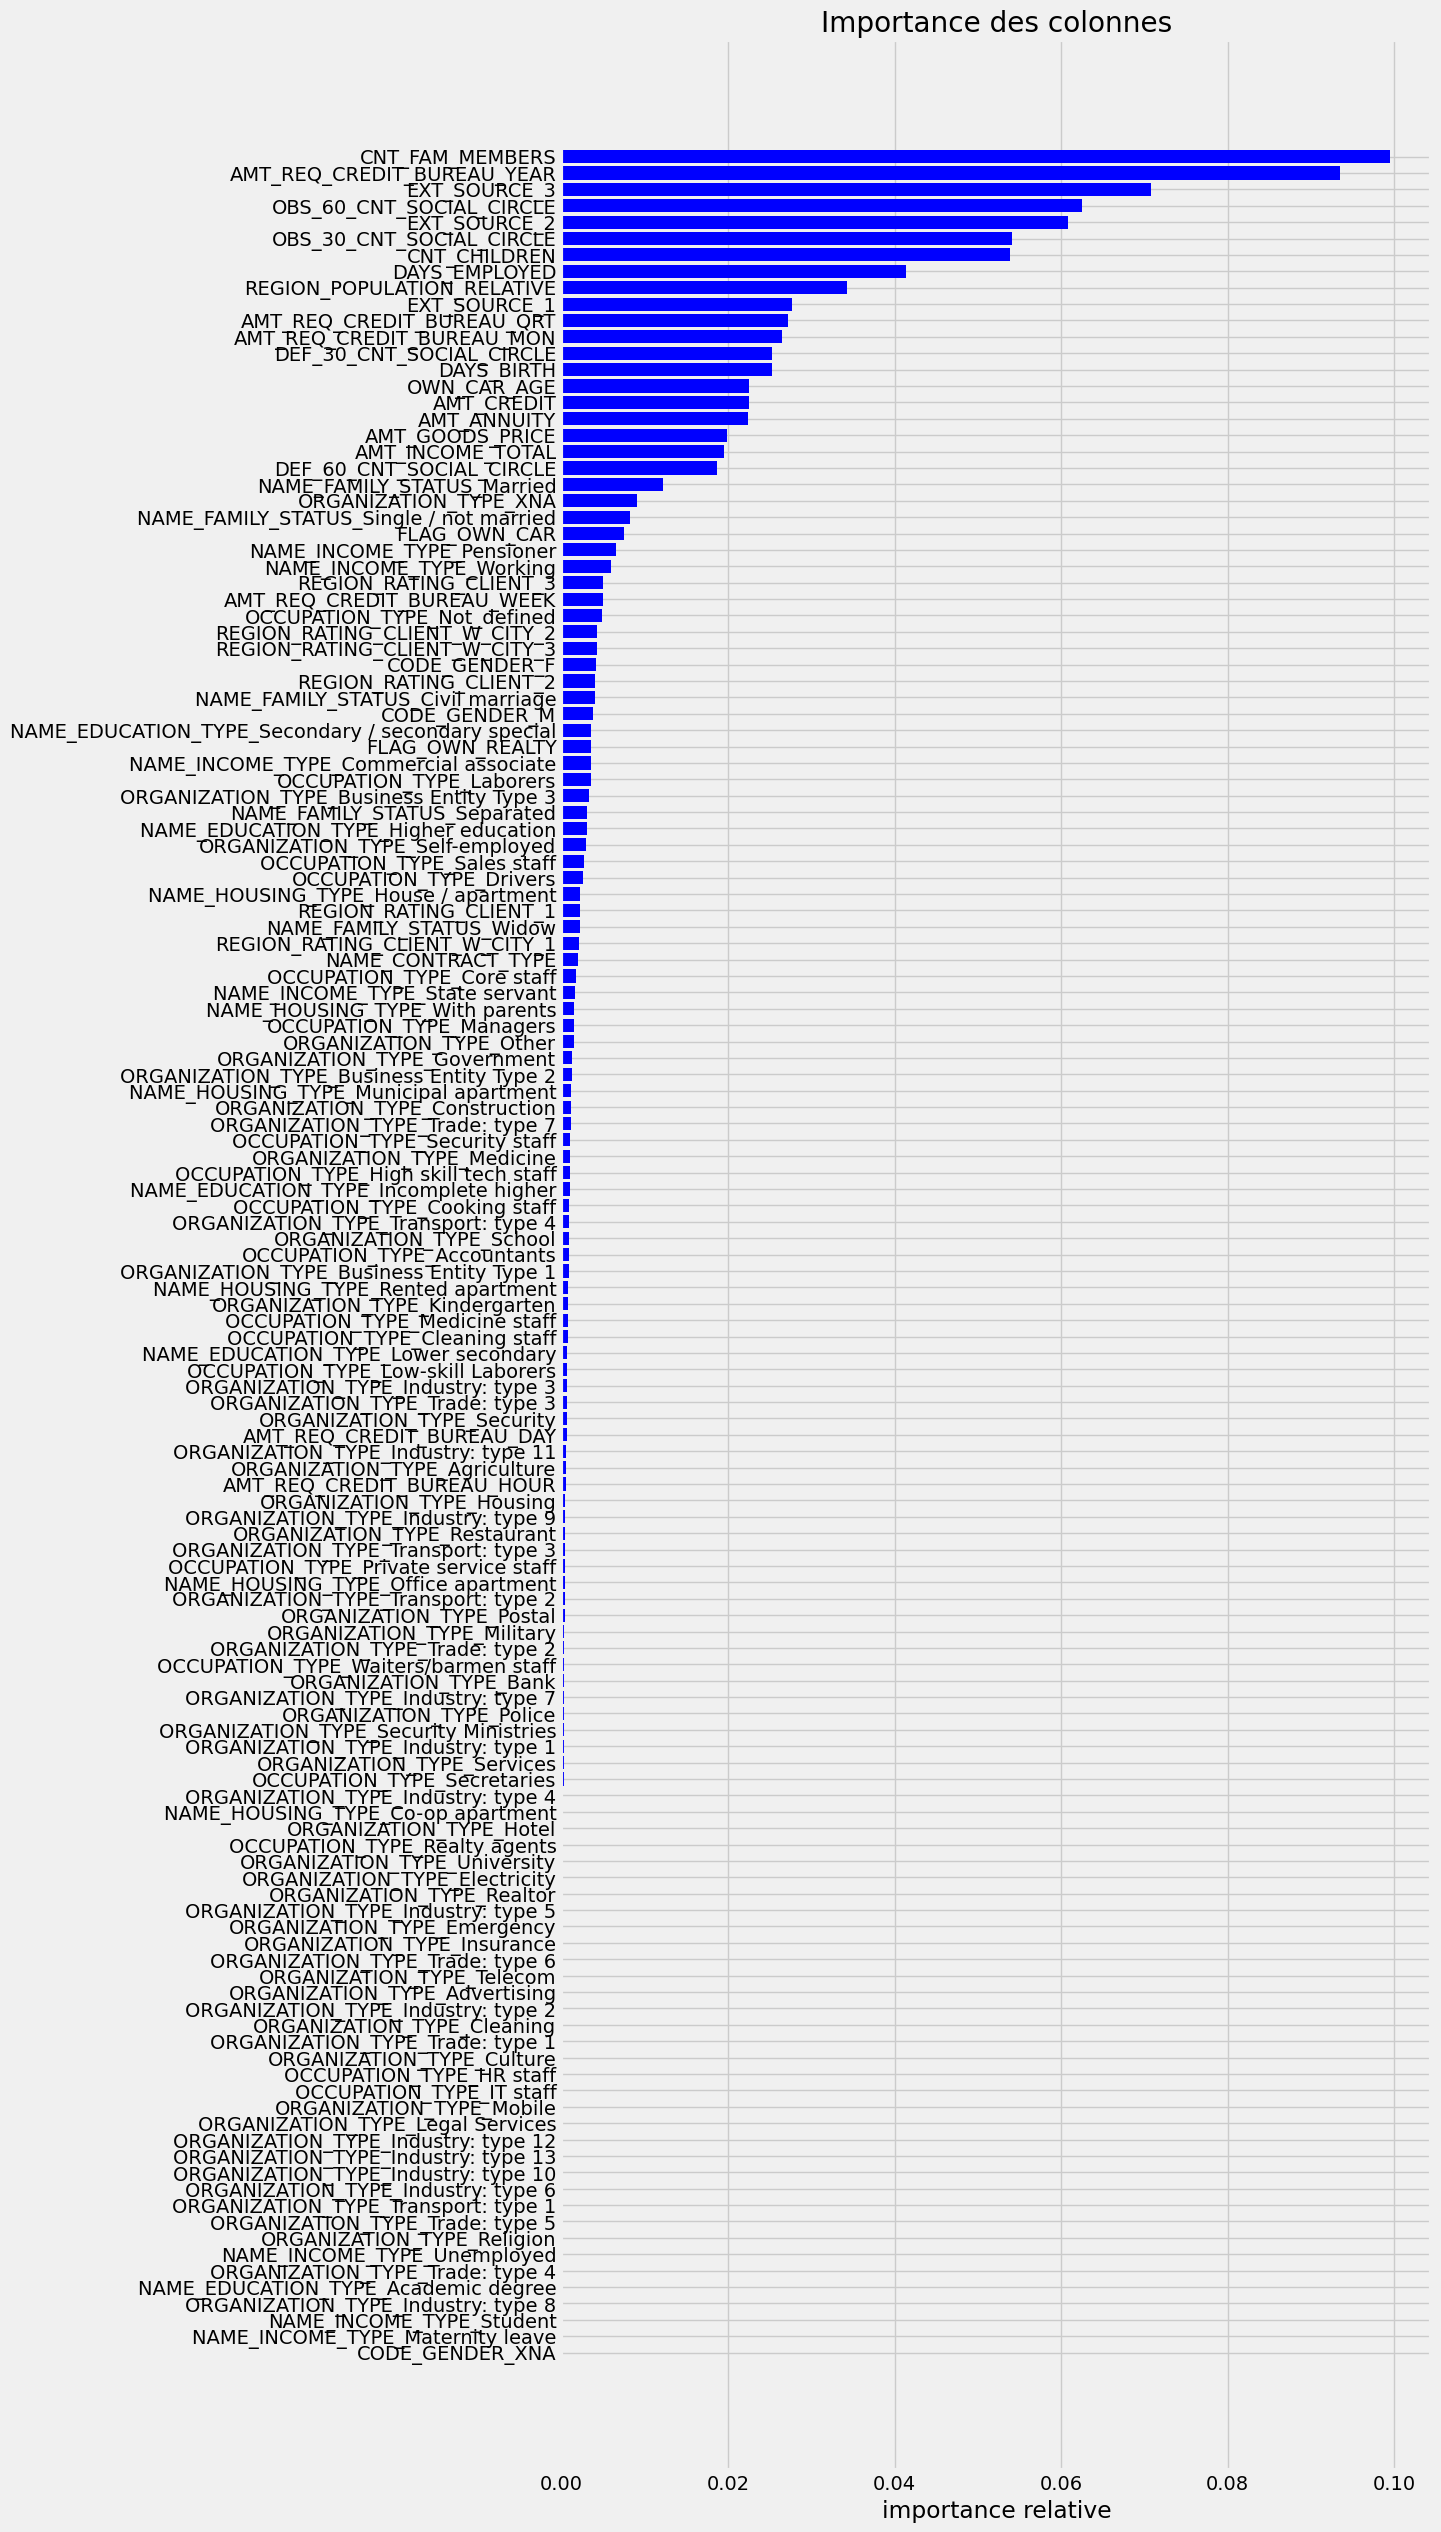

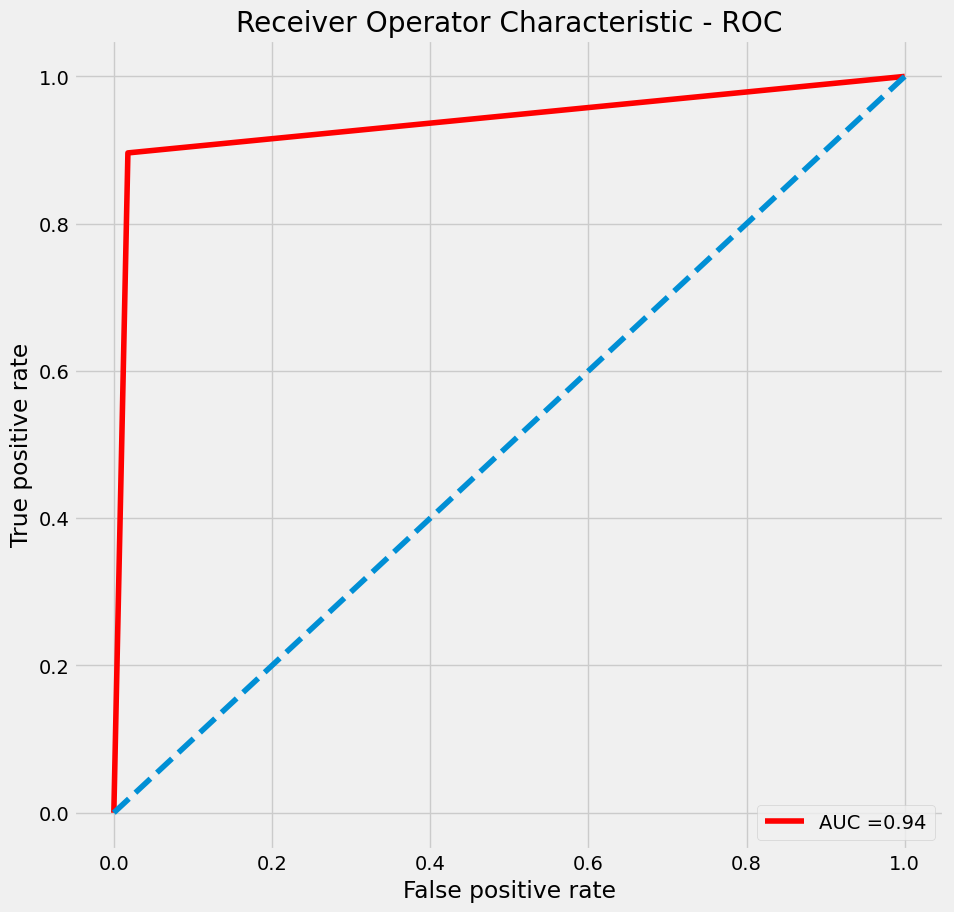

F1= 0.9364215704542913
F1 pondéré= 0.6290596150837114
----------------------------------------


,pred_0,pred_1
test_0,55061,997
test_1,5827,50254


----------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     56058
           1       0.98      0.90      0.94     56081

    accuracy                           0.94    112139
   macro avg       0.94      0.94      0.94    112139
weighted avg       0.94      0.94      0.94    112139



In [146]:
#Appel de la fonction : randomf(X_train, y_train, n_estimators, oob_score, n_jobs, class_weight):
#Note : class_weight = "balanced" (équivaut à {0:.080863,1:0.919137}) s'utilise avec la configuration 1 de la préparation des data (sans équilibrage avec smote NC); sinon mettre None. On peut aussi utilisr "balanced_subsample"
estimator,y_pred, indices, liste_variables = randomf(X_train, X_test, y_train,y_test, 10, True , -1, None)
score(estimator,y_pred,X_train,X_test,y_train,y_test)
score_ponderation(y_test,y_pred)

In [147]:
#selection des colonnes par un seuil
select = SelectFromModel(estimator, prefit=True, threshold=0.01)

X_train2 = select.transform(X_train)
X_train2 = pd.DataFrame(X_train2)
X_train2.index=X_train.index
print(X_train2.shape)

X_test2 = select.transform(X_test)
X_test2 = pd.DataFrame(X_test2)
X_test2.index=X_test.index
print(X_test2.shape)

#Renommage des colonnes de X_train2 et X_test2 : noms perdus lors de l'opération SelectFromModel :

#Forçage des types et transformation des listes en dataframe
X_train2.columns = X_train2.columns.astype(str)
X_test2.columns = X_test2.columns.astype(str)
df_liste_variables=pd.DataFrame(liste_variables)
df_indices=pd.DataFrame(indices)

#Renommage des colonnes
j=df_indices.shape[0]-1
for i in range(X_train2.shape[1]):
    k=df_indices.iloc[j-i,0]
    X_train2.columns.values[i]=df_liste_variables.iloc[k,0]
    X_test2.columns.values[i]=df_liste_variables.iloc[k,0]
   

    

X has feature names, but SelectFromModel was fitted without feature names


(448553, 21)
(112139, 21)


X has feature names, but SelectFromModel was fitted without feature names


In [ ]:
X_train2.info()

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


La proportion de target dans le jeu d'entrainement :
0    0.500026
1    0.499974
Name: TARGET, dtype: float64
La proportion des prédictions faite est :
0    0.542915
1    0.457085
dtype: float64
--------------------------------------------------------------------------------
Voici les résultats :
score train : 0.9936 ; score test : 0.9499
----------------------------------------


,pred_0,pred_1
test_0,55663,395
test_1,5219,50862


----------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     56058
           1       0.99      0.91      0.95     56081

    accuracy                           0.95    112139
   macro avg       0.95      0.95      0.95    112139
weighted avg       0.95      0.95      0.95    112139

----------------------------------------
L'aire sous la courbe ROC est : 0.95


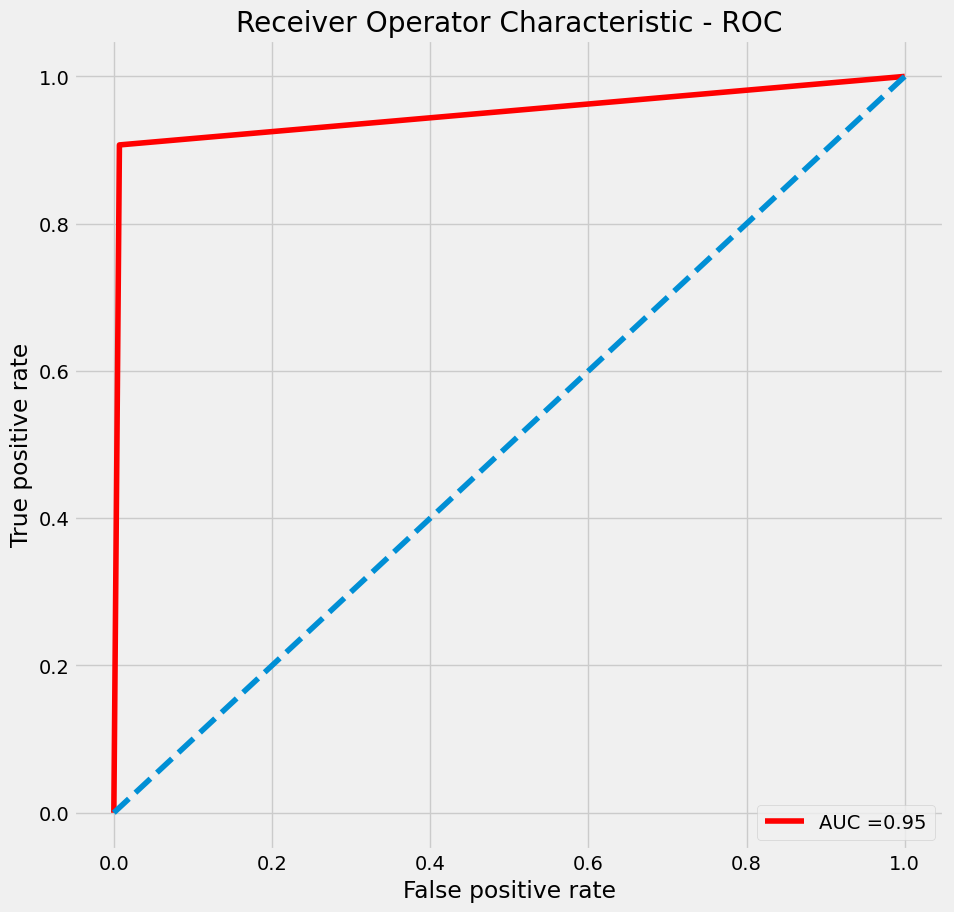

F1= 0.9476979261771228
F1 pondéré= 0.6592227284215438
----------------------------------------


,pred_0,pred_1
test_0,55663,395
test_1,5219,50862


----------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     56058
           1       0.99      0.91      0.95     56081

    accuracy                           0.95    112139
   macro avg       0.95      0.95      0.95    112139
weighted avg       0.95      0.95      0.95    112139



In [148]:
#Création d'une 2eme fonction random forest pour garder l'historique de la première
estimator2, y_pred=randomf2(X_train2, X_test2, y_train,y_test, 10, True , -1, None)
score(estimator2,y_pred,X_train2,X_test2,y_train,y_test)
score_ponderation(y_test,y_pred)

In [ ]:
#Configuration 3
estimator,y_pred,indices, liste_variables = randomf(X_train, X_test, y_train,y_test, 10, True , -1, "balanced")
score(estimator,y_pred,X_train,X_test,y_train,y_test)
score_ponderation(y_test,y_pred)

In [ ]:
#Configuration 3
estimator,y_pred,indices, liste_variables = randomf(X_train, X_test, y_train,y_test, 100, True , -1, "balanced_subsample")
score(estimator,y_pred,X_train,X_test,y_train,y_test)
score_ponderation(y_test,y_pred)

In [ ]:
liste_variables_finale_rf=X_train2.columns
liste_variables_finale_rf

In [ ]:
#Transformation de l'index en liste
liste_variables_finale_rf=liste_variables_finale_rf.tolist()
liste_variables_finale_rf

#### <a name="C5.2.4.2">5.2.4.2 Optimisation du modèle </a>

In [ ]:
#rfc=RandomForestClassifier(random_state=42, n_jobs=-1)
rfc=RandomForestClassifier( n_jobs=-1)

In [ ]:
param_grid = { 
    'n_estimators': [10,200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'oob_score' : [True],
    'criterion' :['gini', 'entropy', 'log_loss']
}

In [ ]:
param_grid = { 
    'n_estimators': [10,100,200,300],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [6,8],
    'oob_score' : [True],
    'criterion' :['gini', 'entropy', 'log_loss']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train2, y_train)

In [ ]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 200,
 'oob_score': True}

In [ ]:
#Prendre les bes_params ci-dessus
#Best paramètres pour X_train
rfc1=RandomForestClassifier(max_features='log2', n_estimators= 200, max_depth=8, oob_score=True, criterion='entropy', n_jobs=-1)
#rfc1=RandomForestClassifier(max_features='log2', oob_score=True,n_estimators= 200,n_jobs=-1)

In [ ]:
rfc1.fit(X_train2, y_train)

In [ ]:
y_pred=rfc1.predict(X_test2)

In [ ]:
score(rfc1, y_pred, X_train2,X_test2, y_train,y_test)
score_ponderation(y_test,y_pred)

#### <a name="C5.2.4.3">5.2.4.3 Interprétation locale des features </a>

##### <a name="C5.2.4.3.1">5.2.4.3.1 SHAP </a>

In [ ]:
explainer = TreeExplainer(estimator2,n_samples=2, feature_perturbation="interventional",fast=True,parallel=True)

In [ ]:
shap_values = np.array(explainer.shap_values(X_train2))

In [ ]:
print(shap_values.shape)

In [ ]:
print(shap_values[1].shape)

In [ ]:
summary_plot(shap_values[1],X_train2)

##### <a name="C5.2.4.3.1">5.2.4.3.2 LIME </a>

In [177]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train2),
    feature_names=X_train2.columns,
    class_names=['0', '1'],
    mode='classification'
)

In [168]:
explainer

In [194]:
exp = explainer.explain_instance(
    data_row=X_test2.iloc[500], 
    predict_fn=estimator2.predict_proba
)

exp.show_in_notebook(show_table=True)
exp.save_to_file('lime.html')

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [191]:
X_test2.head()

,CNT_FAM_MEMBERS,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_3,OBS_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,CNT_CHILDREN,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,EXT_SOURCE_1,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_MON,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_BIRTH,OWN_CAR_AGE,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,DEF_60_CNT_SOCIAL_CIRCLE,NAME_FAMILY_STATUS_Married
365175,0.601518,0.333480,0.325866,3.093878,0.480223,0.134199,-0.681854,-0.433234,-0.037355,0.796735,0.156934,-1.656690,0.023922,-0.674884,-0.382094,-0.672770,-0.330879,-0.287736,-0.334964,-0.903088,1.0
501286,-0.659763,-1.070351,-1.412615,-1.641565,-1.365452,-0.582571,-0.362196,0.231815,-0.037355,-0.196049,0.156934,-1.374051,-0.024589,-0.674884,-0.382094,-0.672770,-0.330879,-0.287736,-0.334964,-1.217021,0.0
99557,-0.659763,0.371243,0.009252,0.179071,0.197840,0.421386,-0.137259,-0.601519,-0.978227,-0.196049,1.960472,-0.540929,-0.894809,3.035764,-0.382094,3.071083,-0.330879,-0.287736,-0.334964,4.355751,1.0
455206,-0.659763,-0.924789,-1.000760,-1.240940,-0.909491,0.366970,-0.301046,0.883379,-0.037355,-0.196049,-0.956227,-0.451814,-0.974249,0.018397,-0.382094,0.026715,-0.330879,-0.287736,-0.334964,0.484125,1.0
281792,0.858024,-0.522572,0.246903,-0.366213,0.458389,0.522400,0.066334,1.011750,-0.037355,0.998636,0.156934,0.732696,0.195955,-0.674884,-0.382094,-0.672770,-0.330879,-0.287736,-0.334964,0.021373,1.0


### <a name="C5.2.5">5.2.5 LightGBM </a>

#### <a name="C5.2.5.1">5.2.5.1 Création du modèle </a>

In [ ]:
#appel de : def lightgbm(X_train, X_test, y_train, y_test, learning_rate, metric, n_estimators):
gbm, modelgbm, y_pred= lightgbm(X_train2, X_test2, y_train, y_test, 0.15,'l1',500)
score(modelgbm,y_pred,X_train2,X_test2,y_train,y_test)
score_ponderation(y_test,y_pred)

CODE CI-DESSOUS EN OPTION SI BESOIN

In [ ]:
#Combien de fois la colonne est utilisée dans le modèle ?
sorted(gbm.feature_importances_,reverse=True)

In [ ]:
#Identification des variables à hauteur de 85% du cumulée
temp = 0 
total = sum(gbm.feature_importances_)
for feature in sorted(gbm.feature_importances_, reverse=True):
    temp+=feature
    print(feature)
    if temp/total >= 0.85:
        print(feature,temp/total) # stop when we 
        break

In [ ]:
#The above means let go of all variables after PAY_AMT_5
#y_pred_prob = gbm.predict_proba(X_test_)[:, 1]
#auc_roc_0 = str(roc_auc_score(y_test, y_pred_prob)) # store AUC score without dimensionality reduction
#print('AUC without dimensionality reduction: \n' + auc_roc_0)

#### <a name="C5.2.5.2">5.2.5.2 Optimisation du modèle </a>

In [ ]:
#A n'utiliser que lors de l'optimisation des paramètres
estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', n_estimators = 20, num_leaves = 38)


param_grid = {
    'n_estimators': [x for x in range(24,40,2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}
gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)

### <a name="C5.2.6">5.2.6 XG_BOOST </a>

#### <a name="C5.2.6.1">5.2.6.1 Création du modèle </a>

In [ ]:
#Appel de la fonction : def xgboost(X_train, X_test, y_train, y_test, objective, colsample_bytree, learning_rate,max_depth,alpha,n_estimators)
modelxg, y_pred = xgboost(X_train2, X_test2, y_train, y_test, 'binary:logistic',0.3,0.1,5,10,500)
score(modelxg,y_pred,X_train2,X_test2,y_train,y_test)
score_ponderation(y_test,y_pred)

#### <a name="C5.2.6.2">5.2.6.2 Optimisation du modèle </a>

In [ ]:
#Recherche hyperparamètre
#X_data = df_app_train
#y_data = df_app_train['TARGET']
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

print((cv_results["test-rmse-mean"]).tail(1))

In [ ]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [ ]:
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
xgb.plot_tree(xg_reg,num_trees=2)
plt.rcParams['figure.figsize'] = [500, 500]
plt.show()

### <a name="C5.2.7">5.2.7 Autres modèles </a>

In [ ]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train2, X_test2, y_train, y_test)
model_dictionary = clf.provide_models(X_train2,X_test2,y_train,y_test)
print(models)

## <a name="C5.3">5.3 Création de variables </a>

### <a name="C5.3.1">5.3.1 ACP </a>

In [ ]:
#Affichage de la liste des variables
liste_variables_finale_rf

In [ ]:
#Création de la dataframe avec seulement les 16 colonnes de rf
df_app_train2=df_app_train.copy()
df_app_train2.info()

In [ ]:
correlation(df_app_train2)

In [ ]:
# construct a dataframe using pandas
df=df_app_train2[['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']]
# plotting correlation heatmap
correlation(df)

# Scale data before applying PCA
scaling=StandardScaler()
 
# Use fit and transform method
scaling.fit(df)
Scaled_data=scaling.transform(df)
 
# Set the n_components=3
pca=PCA(n_components=3)
pca.fit(Scaled_data)
x=pca.transform(Scaled_data)
 
# Check the dimensions of data after PCA
print(x.shape)

In [ ]:
#Enregistrement des variances dans une variable :
scree = (pca.explained_variance_ratio_*100).round(2)
    
#Calcul et enregistrement des sommes cumulées
scree_cum = scree.cumsum().round()
    
#Création de la liste des composantes
x_list = range(1, 3+1)
list(x_list)

#Affichage de l'éboulis des valeurs propres
plt.figure(figsize=(10, 10))
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [ ]:
#Calcul des composantes
pcs = pca.components_
    
#Création du dataframe associé
pcs = pd.DataFrame(pcs)

#Renommage des index et colonnes
pcs.columns = df.columns
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

#Affichage du heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=False, square=True, cmap="coolwarm", fmt="0.2f")


x_y = (0,1)
#Affichage du graph des corrélations
cercle_correlation(pca, x_y, df.columns)
    


In [ ]:
pcs.head()

In [ ]:
pcs.iloc[0,0]

In [ ]:
pcs.iloc[0,1]

In [ ]:
df_app_train['F1']=df_app_train2['AMT_CREDIT']*pcs.iloc[0,0]+df_app_train2['AMT_ANNUITY']*pcs.iloc[0,1]+df_app_train2['AMT_GOODS_PRICE']*pcs.iloc[0,2]

In [ ]:
df_app_train.info()

In [ ]:
df_app_train = df_app_train.drop ('AMT_CREDIT',axis=1)
df_app_train = df_app_train.drop ('AMT_ANNUITY',axis=1)
df_app_train = df_app_train.drop ('AMT_GOODS_PRICE',axis=1)

In [ ]:
df_app_train.info()

### <a name="C5.3.2">5.3.2 Polynomial features </a>

In [ ]:
poly_features = df_app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','TARGET']]
poly_features['DAYS_BIRTH']=poly_features['DAYS_BIRTH']
#Séparation de TARGET du reste
poly_target = poly_features['TARGET']
poly_target =pd.DataFrame(poly_target)

poly_features = poly_features.drop(columns = ['TARGET'])

#Appel de la fonction polynomial_features
poly_featured= polynomial_features(3, poly_features, poly_target)

poly_featured.head()

In [ ]:
df_tmp = df_app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','TARGET']]
corrs = df_tmp.corr()
plt.figure(figsize = (10, 10))
# Heatmap
sns.heatmap(corrs, cmap = plt.cm.RdYlBu_r, square=True, vmin = -1, annot = True, vmax = 1)
plt.title('Heatmap de correlation');

In [ ]:
corrs = poly_featured.corr()
plt.figure(figsize = (10, 10))
# Heatmap
sns.heatmap(corrs, cmap = plt.cm.RdYlBu_r, square=True, vmin = -0.194542, annot = False, vmax = 0.181664)
plt.title('Heatmap de correlation');

In [ ]:
df_app_train.info()

In [ ]:
poly_featured.info()

In [ ]:
poly_featured = poly_featured.drop('TARGET',axis=1)

In [ ]:
#Suppression des colonnes déjà dans le dataframe df_app_train
poly_featured = poly_featured.drop('EXT_SOURCE_1',axis=1)
poly_featured = poly_featured.drop('EXT_SOURCE_2',axis=1)
poly_featured = poly_featured.drop('EXT_SOURCE_3',axis=1)
poly_featured = poly_featured.drop('DAYS_BIRTH',axis=1)


In [ ]:
# Merge polynomial features into training dataframe
app_train_poly = df_app_train.merge(poly_featured, on = 'SK_ID_CURR', how = 'left')
app_train_poly.info()

In [ ]:
app_train_poly.head()

In [ ]:
df_app_train=app_train_poly.copy()

In [ ]:
df_app_train.info()

### <a name="C5.3.4">5.3.3 Qualité clientelle (K-Means) </a>

In [ ]:
df_previous_application.info()

In [ ]:
df_previous_application.head()

In [ ]:
#Copie de la dataframe
df_previous_app=df_previous_application.copy()

df_previous_application2=df_previous_application.copy()
df_previous_application2.set_index('SK_ID_PREV', inplace = True)

In [ ]:
#Mise en index de SK_ID_PREV 
df_previous_app.set_index('SK_ID_PREV', inplace = True)
#Suppresion des colonnes non utiles 
df_previous_app.drop(columns='SK_ID_CURR', axis=1, inplace = True)
df_previous_app.drop(columns='WEEKDAY_APPR_PROCESS_START', axis=1, inplace = True)
df_previous_app.drop(columns='HOUR_APPR_PROCESS_START', axis=1, inplace = True)
df_previous_app.drop(columns='FLAG_LAST_APPL_PER_CONTRACT', axis=1, inplace = True)
df_previous_app.drop(columns='NFLAG_LAST_APPL_IN_DAY', axis=1, inplace = True)
df_previous_app.drop(columns='RATE_INTEREST_PRIMARY', axis=1, inplace = True)
df_previous_app.drop(columns='RATE_INTEREST_PRIVILEGED', axis=1, inplace = True)
df_previous_app.drop(columns='NAME_CASH_LOAN_PURPOSE', axis=1, inplace = True)
df_previous_app.drop(columns='DAYS_DECISION', axis=1, inplace = True)
df_previous_app.drop(columns='NAME_PAYMENT_TYPE', axis=1, inplace = True)
df_previous_app.drop(columns='NAME_TYPE_SUITE', axis=1, inplace = True)
df_previous_app.drop(columns='NAME_GOODS_CATEGORY', axis=1, inplace = True)
df_previous_app.drop(columns='NAME_PORTFOLIO', axis=1, inplace = True)
df_previous_app.drop(columns='NAME_PRODUCT_TYPE', axis=1, inplace = True)
df_previous_app.drop(columns='CHANNEL_TYPE', axis=1, inplace = True)
df_previous_app.drop(columns='SELLERPLACE_AREA', axis=1, inplace = True)
df_previous_app.drop(columns='NAME_SELLER_INDUSTRY', axis=1, inplace = True)
df_previous_app.drop(columns='NAME_YIELD_GROUP', axis=1, inplace = True)
df_previous_app.drop(columns='PRODUCT_COMBINATION', axis=1, inplace = True)
df_previous_app.drop(columns='DAYS_FIRST_DRAWING', axis=1, inplace = True)
df_previous_app.drop(columns='DAYS_FIRST_DUE', axis=1, inplace = True)
df_previous_app.drop(columns='DAYS_LAST_DUE_1ST_VERSION', axis=1, inplace = True)
df_previous_app.drop(columns='DAYS_LAST_DUE', axis=1, inplace = True)
df_previous_app.drop(columns='DAYS_TERMINATION', axis=1, inplace = True)


In [ ]:
#Suppression des lignes contenant des nulls
df_previous_app= df_previous_app.dropna(axis=0)

In [ ]:
df_previous_app.info()

In [ ]:
#Standardisation

std_scaled_knn=preprocessing.StandardScaler()
X_previous,std_scaled_knn=standardisation(df_previous_app,std_scaled_knn)


In [ ]:
#Encodage
X_previous=encodage_objet(X_previous)

In [ ]:
# Une liste vide pour enregistrer les inerties :  
intertia_list = []

# Notre liste de nombres de clusters : 
k_list = range(1, 10)

# Pour chaque nombre de clusters : 
for k in k_list : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k)
    
    # On entraine
    kmeans.fit(X_previous)
    
    # On enregistre l'inertie obtenue : 
    intertia_list.append(kmeans.inertia_)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")

ax = plt.plot(k_list, intertia_list)

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_previous)

In [ ]:
#Ajout des clusters à la df train en la copiant avant
train_cluster=X_previous.copy()
kmeans.labels_
train_cluster["cluster"] = kmeans.labels_
train_cluster.head()

In [ ]:
train_cluster['SK_ID_CURR']=np.nan

In [ ]:
#Je rapporte les valeur de SK_ID_CURR dans le dataframe
for index in train_cluster.index:
    train_cluster.loc[index, 'SK_ID_CURR']= df_previous_application2.loc[index, 'SK_ID_CURR']
#Cast en int de la colonne SK_ID_CURR
train_cluster['SK_ID_CURR'] = train_cluster['SK_ID_CURR'].astype('int')

In [ ]:
train_cluster.head()

In [ ]:
#Détection des SK_ID_CURR ayant plus de 1 cluster
nb_cluster=train_cluster.groupby([ 'SK_ID_CURR'])['cluster'].size().reset_index()
nb_cluster.columns = ['SK_ID_CURR', 'qte_cluster']
nb_cluster.head()

In [ ]:
#On ne garde que les ID ayant 1 seul cluster
cluster_non_unique=nb_cluster.loc[nb_cluster['qte_cluster']>1]
cluster_non_unique.set_index('SK_ID_CURR', inplace = True)
cluster_non_unique.head()

In [ ]:
cluster_non_unique.info()

In [ ]:
#j'extrait de train_cluster tous les IDs n'ayant qu'un seul cluster : je supprime donc les autres
cluster_non_unique_liste=cluster_non_unique.index.tolist()

In [ ]:
#Je supprimes les lignes concernée dans df_app_train
df_app_train.drop(cluster_non_unique_liste,0, inplace=True, errors='ignore')

In [ ]:
df_app_train.info()

In [ ]:
#Même principe sur train_cluster mais avant passage de SK_ID_CURR en index en faisant d'abord une copie au cas où
train_cluster['SK_ID_CURR_CC']=train_cluster['SK_ID_CURR']
train_cluster.set_index('SK_ID_CURR', inplace = True)
train_cluster.drop(cluster_non_unique_liste,0, inplace=True, errors='ignore')

In [ ]:
#Récupération des 2 colonnes utiles
df_cluster=train_cluster[['SK_ID_CURR_CC','cluster']]

In [ ]:
df_cluster.head()

In [ ]:
#on drop la colonnes SK_ID_CURR_CC
df_cluster.drop(columns='SK_ID_CURR_CC', axis=1, inplace = True)
df_cluster.head()

In [ ]:
#Je merge la colonne cluster dans df_app_train
df_app_train_cluster=pd.merge(df_app_train, df_cluster, left_index=True, right_index=True)
df_app_train_cluster.head()

In [ ]:
#Je vérifie qu'il n'y a pas de NA
df_app_train_cluster.info()

In [ ]:
#Cast de cluster en objet pour éviter la pondération sur les chiffres
df_app_train_cluster = df_app_train_cluster.astype({'cluster': object})

In [ ]:
#Je renomme ma dataframe pour la faire fonctionner dans mes différents modèles
df_app_train=df_app_train_cluster.copy()

# 6. Conclusion

Voir notebook de présentation

# FIN